In [ ]:
!git clone https://github.com/JY251/stable-baselines3.git
!pip install git+https://github.com/JY251/stable-baselines3.git

fatal: destination path 'stable-baselines3' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JY251/stable-baselines3.git to /tmp/pip-req-build-geqrp7v7
  Running command git clone --filter=blob:none --quiet https://github.com/JY251/stable-baselines3.git /tmp/pip-req-build-geqrp7v7
  Resolved https://github.com/JY251/stable-baselines3.git to commit 4852e50bfc897f8e4f9f8ad0144a0c453fddff12
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import gym
import numpy as np
from gym.envs.classic_control import PendulumEnv
import torch as th
from stable_baselines3.sac.policies import CnnPolicy
from stable_baselines3 import SAC
from gym import Wrapper, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import collections
from PIL import Image
import cv2
import time as time
# from skimage.transform import rescale, resize, downscale_local_mean
def resize(frame , width, height):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
    return frame[:, :, ]

## image saving  compression image
class RGBArrayAsObservationWrapper(Wrapper):
    def __init__(self, env , test = False):
        super(RGBArrayAsObservationWrapper, self).__init__(env)

        self.i = 0
        self.test = test

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir
        env.reset() ## initialize the environment! for
        dummy_obs = resize(env.render('rgb_array') , 64 , 64).astype(np.uint8)## before PPO, we estimate the size image.
        self.num_repeats = 5 ## repeathing images to check the direction of the cartpole
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.num_repeats, *dummy_obs.shape), dtype=dummy_obs.dtype)
        self.dq = collections.deque(maxlen=self.num_repeats)
        self.reset()
    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        obs = self.env.render("rgb_array")
        obs = resize(obs ,64 , 64).astype(np.uint8)
        for _ in range(self.num_repeats): ## stacking the observation on the dq
            self.dq.append(obs)
        obs_stacked = np.stack(self.dq)
        # input()
        return obs_stacked
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = self.env.render("rgb_array")
        ## jpad
        obs = resize(obs , 64, 64).astype(np.uint8)
        # Save the image


        if self.test:
          im_path = os.path.join(self.image_dir, f"frame_{self.i}.png")
          self.i += 1
          Image.fromarray(obs).save(im_path)
        self.dq.append(obs)
        obs_stacked = np.stack(self.dq)
        # print(obs_stacked)
        return obs_stacked, reward, done, info



In [ ]:
start = time.time()
TEST_COUNT = 100
pendulum_env = gym.make("CartPole-v1")
image_dir="images/"
os.makedirs(image_dir, exist_ok=True)
pendulum_env = RGBArrayAsObservationWrapper(pendulum_env)
check_env(pendulum_env, warn=True)
pendulum_env.reset()
log_dir = "logs/"

os.makedirs(log_dir, exist_ok=True)## make directory

# env.env.ale.saveScreenPNG('test_image2.png')
env = Monitor(pendulum_env, log_dir) ##monitor wrapper for Gym environments, it is used to know the episode reward, length, time and other data.
model = PPO("CnnPolicy", env, verbose=0) ## use the PPO model and verbose = 0 with the cnnpolicy
## line 44-45 through this policy and with PPO model and enviroment and doing the CNN policy.
model.learn(10) ## running times of stpes
end = time.time()
timecost = end - start
print(timecost)


21.970040321350098


In [ ]:
pendulum_env = gym.make("CartPole-v1")
image_dir="images_learning_train/"
os.makedirs(image_dir, exist_ok=True)
pendulum_env = RGBArrayAsObservationWrapper(pendulum_env , True)
env = pendulum_env
for i in range(1600):
  state = env.reset()
  done = False
  step = 0
  tot_rewards = 0
  while not done:
    step += 1
    action,_ = model.predict(state)
    state , action , reward , done = env.step(action)
    tot_rewards += reward

  print("Reward in this episode" , tot_rewards , step , i)



pendulum_env = gym.make("CartPole-v1")
image_dir="images_learning_test/"
os.makedirs(image_dir, exist_ok=True)
pendulum_env = RGBArrayAsObservationWrapper(pendulum_env , True)
env = pendulum_env
for i in range(400):
  state = env.reset()
  done = False
  step = 0
  tot_rewards = 0
  while not done:
    step += 1
    action,_ = model.predict(state)
    state , action , reward , done = env.step(action)
    tot_rewards += reward

  print("Reward in this episode" , tot_rewards , step , i)


Reward in this episode 1 21 0
Reward in this episode 1 22 1
Reward in this episode 1 13 2
Reward in this episode 1 13 3
Reward in this episode 1 12 4
Reward in this episode 1 14 5
Reward in this episode 1 18 6
Reward in this episode 1 18 7
Reward in this episode 1 22 8
Reward in this episode 1 48 9
Reward in this episode 1 27 10
Reward in this episode 1 39 11
Reward in this episode 1 12 12
Reward in this episode 1 11 13
Reward in this episode 1 22 14
Reward in this episode 1 23 15
Reward in this episode 1 28 16
Reward in this episode 1 20 17
Reward in this episode 1 24 18
Reward in this episode 1 9 19
Reward in this episode 1 25 20
Reward in this episode 1 12 21
Reward in this episode 1 31 22
Reward in this episode 1 13 23
Reward in this episode 1 27 24
Reward in this episode 1 13 25
Reward in this episode 1 31 26
Reward in this episode 1 26 27
Reward in this episode 1 30 28
Reward in this episode 1 17 29
Reward in this episode 1 18 30
Reward in this episode 1 28 31
Reward in this epis

In [ ]:
png_folder = '/content/images_learning2'

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class LinearVAE(nn.Module):
    def __init__(self, in_dim, latent_dim, device = "cpu"):
        super(LinearVAE, self).__init__()
        self.h, self.w = in_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_1 = nn.Linear(self.h * self.w, 1024)
        self.encoder_2 = nn.Linear(1024, 1024)

        # Latent Space
        self.latent_layer_mean = nn.Linear(1024, latent_dim)
        self.latent_layer_variance = nn.Linear(1024, latent_dim)
        self.latent_decoder = nn.Linear(latent_dim, 1024)

        # Decoder
        self.decoder_1 = nn.Linear(1024, 1024)
        self.decoder_2 = nn.Linear(1024, self.h * self.w)

        self.to(device)

    def encode(self, x):
        x = F.relu(self.encoder_1(x))
        x = F.relu(self.encoder_2(x))
        x = x.reshape(-1, 1024)
        m , v = self.latent_layer_mean(x), self.latent_layer_variance(x)
        return m , v

    def reparameterization(self, mean, variance):
        std = T.exp(0.5 * variance)
        eps = T.rand_like(std)
        return mean + std * eps

    def decode(self, x):
        x = self.latent_decoder(x).reshape(-1, 1024)
        x = F.relu(self.decoder_1(x))
        x = T.sigmoid(self.decoder_2(x))
        return x

    def forward(self, x):
        mean, variance = self.encode(x)
        z = self.reparameterization(mean, variance)
        return self.decode(z), mean, variance

import torch as T

class CustomDataset(T.utils.data.Dataset):
    """
    data: iterable
    """
    def __init__(self, data, device):
        self.data = T.tensor(data).float().to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]



In [ ]:

def save_imgs(imgs, base_path):
    for idx, img in enumerate(imgs):
        fig = plt.figure(figsize=(25,25))
        plt.title(f"I:{idx}")
        plt.savefig(f"{base_path}/{idx}.jpg")

In [ ]:
# import torch as T
# import torch.nn.functional as F
# import numpy as np
# from matplotlib import pyplot as plt
# from scipy.io import loadmat
# import os , cv2
# from matplotlib.pyplot import imread




# def loss_function(true_batch, recon_batch, mean, logvar, beta):
#     """
#     Minimize the reconstruction loss + KL divergence
#     """
#     recon_loss = F.mse_loss(recon_batch, true_batch)
#     kl_div = -0.5 * T.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     return recon_loss + beta * kl_div


# def train(model, optimizer, epoch, dataloader, beta):
#     """
#     Performs one iteration of training using examples from dataloader.
#     Assumption: Data is of shape (n_examples, height, width, n_channels)
#     """
#     model.train()
#     train_loss = []
#     for _, x in enumerate(dataloader):
#         optimizer.zero_grad()
#         # After permutation, shape of data (n_examples, n_channels, height, width)
#         # x_ = x.permute(0, 3, 1, 2)
#         x_ = x.reshape(x.shape[0], -1)
#         recon_batch, mean, variance = model.forward(x_)
#         loss = loss_function(x_, recon_batch, mean, variance, beta)
#         train_loss.append(loss.item())
#         loss.backward()
#         optimizer.step()
#     if epoch % 1 == 0:
#         print('====> Epoch: {} Training loss: {:.4f}'.format(epoch, np.mean(train_loss)))
#     return model


# def generate_images(model, z_random):
#     res = model.decode(z_random.squeeze())
#     # return res.permute(0,2,3,1).detach().cpu().numpy()
#     return res.reshape(10, 64, 64).detach().cpu().numpy()

# def save_imgs(imgs, base_path):
#     for idx, img in enumerate(imgs):
#         fig = plt.figure(figsize=(25,25))
#         plt.imshow(img)
#         plt.title(f"I:{idx}")
#         plt.savefig(f"{base_path}/{idx}.jpg")

# if __name__ == "__main__":
#     """
#     n: number of examples to generate
#     latent_dim: dimensions of the bottleneck layer
#     n_epochs: number of epochs to train the model
#     frames: numpy array of frames. shape: (n_examples, height, width) for LinearVAE, (n_examples, height, width, channel) for ConvVAE
#     img_dim: (64, 64)
#     """
#     n = 10
#     latent_dim = 500
#     n_epochs = 5

#     # frame_files = [f for f in os.listdir(mat_folder) if f.endswith('.mat')]

#     # print(frame_files)

#     png_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]

#     frames = []
#     for file_name in png_files:
#       image = imread(os.path.join(png_folder, file_name))
#       frames.append(image.astype(float))

#     #frames = loadmat(mat_folder + "/frame_60.mat")["frames"][:, :, :, 0]
#     #frames = []

#     device = T.device("cuda" if T.cuda.is_available() else "cpu")
#     img_dim = (64, 64)
#     # model = ConvVAE(img_dim, latent_dim, device)
#     encoder = LinearVAE(img_dim, latent_dim, device)
#     # encoder.load_state_dict(T.load("saved_model.pt"))

#     optimizer = T.optim.Adam(encoder.parameters())

#     dataset = CustomDataset(np.array(frames), device)

#     dataloader = T.utils.data.DataLoader(dataset, batch_size = 64)

#     for i in range(1, n_epochs+1):
#         encoder = train(encoder, optimizer, i, dataloader, beta=1)

#     T.save(encoder.state_dict(), "saved_model.pt")

#     normal_distribution = T.distributions.normal.Normal(T.Tensor([0.0]), T.Tensor([1.0]))
#     z_random = normal_distribution.sample((n, latent_dim)).to(device)

#     # pendulum_env = RGBArrayAsObservationWrapper(normal_distribution)
#     # check_env(pendulum_env, warn=True)
#     # # pendulum_env.reset()
#     log_dir = "log/"

#     os.makedirs(log_dir, exist_ok=True)## make directory

#     # env.env.ale.saveScreenPNG('test_image2.png')
#     # env = Monitor(pendulum_env, log_dir) ##monitor wrapper for Gym environments, it is used to know the episode reward, length, time and other data.
#     # model = PPO("CnnPolicy", env, verbose=1) ## use the PPO model and verbose = 0 with the cnnpolicy
#     # ## line 44-45 through this policy and with PPO model and enviroment and doing the CNN policy.
#     # model.learn(100000) ## running times of stpes


#     # recon_dir="recon/"
#     # os.makedirs(recon_dir, exist_ok=True)## make directory
#     # save_imgs(recon_images, "/content/recon")



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


====> Epoch: 1 Training loss: 0.0034
====> Epoch: 2 Training loss: 0.0012
====> Epoch: 3 Training loss: 0.0012
====> Epoch: 4 Training loss: 0.0012
====> Epoch: 5 Training loss: 0.0012


In [ ]:
from matplotlib.pyplot import imread
import os

frames = []
png_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]
from matplotlib.pyplot import imread
for file_name in png_files:
  image = imread(os.path.join(png_folder, file_name))
  frames.append(image.astype(float))




In [ ]:
# print(len(frames))

39024


In [ ]:
# device = T.device("cuda" if T.cuda.is_available() else "cpu")
# img_dim = (64, 64)
# z_random = normal_distribution.sample((n, latent_dim)).to(device)

# # encoder.load_state_dict(T.load("saved_model.pt"))


# recon_images = generate_images(encoder, z_random)
# recon_dir="recon/"
# os.makedirs(recon_dir, exist_ok=True)## make directory
# save_imgs(recon_images, "/content/recon")

In [ ]:
# Install the library
%pip install pythae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 kB 14.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.datasets as datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
png_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]
frames = []
for file_name in png_files[:10]:
  image = imread(os.path.join(png_folder, file_name))
  frames.append(image.astype(float))

frames = np.array(frames)

train_data , test_data = CustomDataset(frames[:-10000] , device) , CustomDataset(frames[-10000:], device)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.default_architectures import Encoder_VAE_MLP, Decoder_AE_MLP

In [ ]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_epochs=10, # Change this to train the model a bit more
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)}
)


model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16
)

model = VAE(
    model_config=model_config,
    encoder=Encoder_VAE_MLP(model_config),
    decoder=Decoder_AE_MLP(model_config)
)

In [ ]:
from pythae.data.datasets import DatasetOutput

class MyCustomDataset(datasets.ImageFolder):

    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root=root, transform=transform, target_transform=target_transform)

    def __getitem__(self, index):
        X, _ = super().__getitem__(index)

        return DatasetOutput(
            data=X
        )

from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor() # the data must be tensors
])


In [ ]:
print(os.path.exists('images_learning_train'))

train_data , test_data = MyCustomDataset(root = 'images_learning_train') , MyCustomDataset('images_learning_test')

pipeline = TrainingPipeline(
    training_config=config,
    model=model
)
pipeline(
    train_data=train_data,
    eval_data=test_data
)

True


FileNotFoundError: ignored

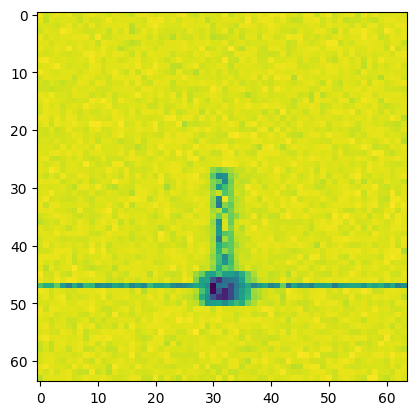

In [ ]:
for frame in frames:

  t_img = T.from_numpy(frame.reshape(1, -1)).float().to(device)
  mean , var = encoder.encode(t_img)

  std = T.exp(0.5 * var)

  obs = T.distributions.Normal(loc=mean, scale=std).sample()


  decoded_img = encoder.decode(obs).detach().numpy()
  img = decoded_img.reshape(64, 64)
  plt.imshow(img)



In [ ]:
import cv2
import time as time
# from skimage.transform import rescale, resize, downscale_local_mean
def resize(frame , width, height):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
    return frame[:, :, ]

Using cpu device
Wrapping the env in a DummyVecEnv.


<ipython-input-64-3ce4ebc41d5d>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)


KeyboardInterrupt: ignored

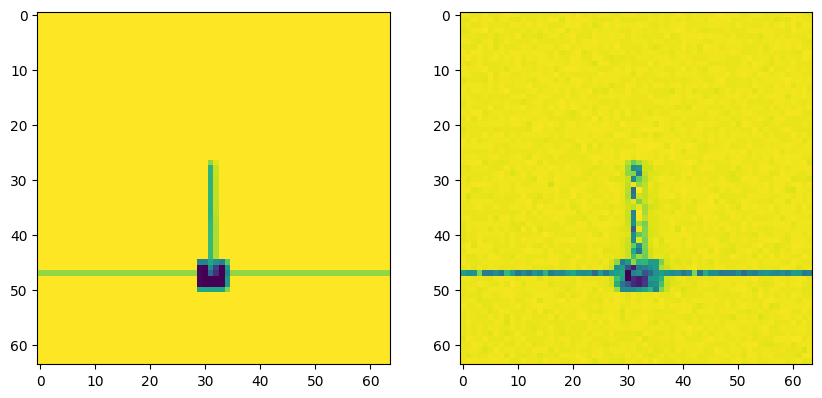

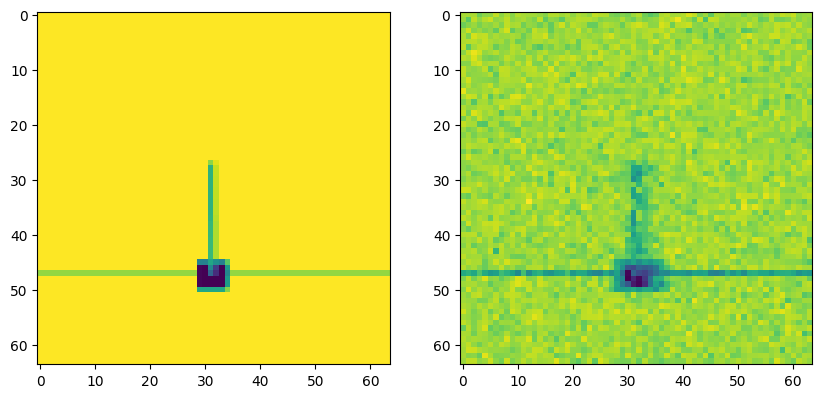

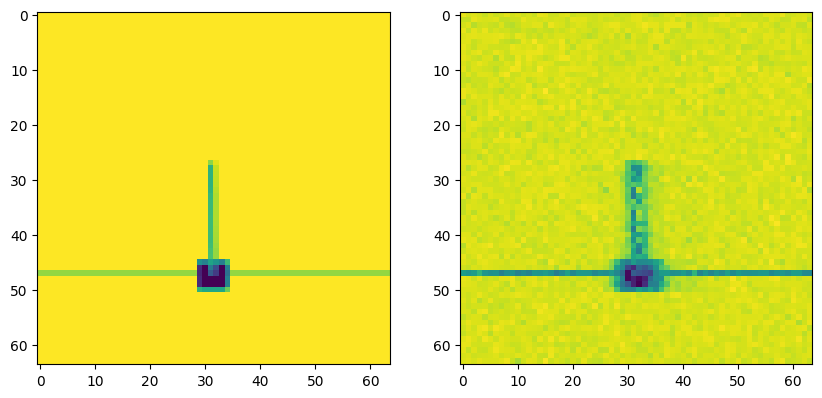

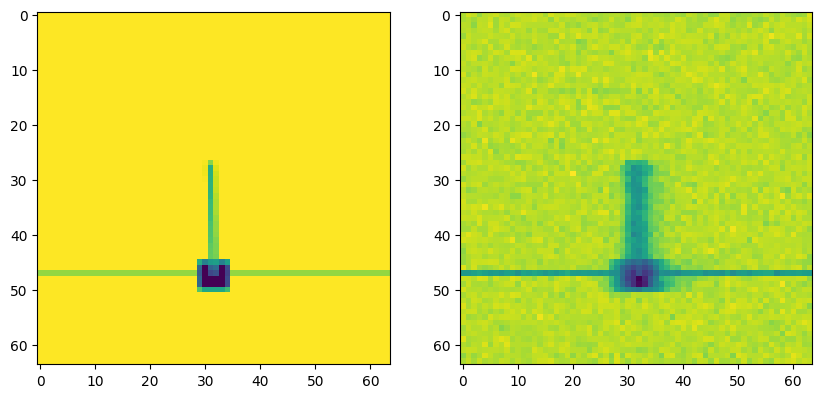

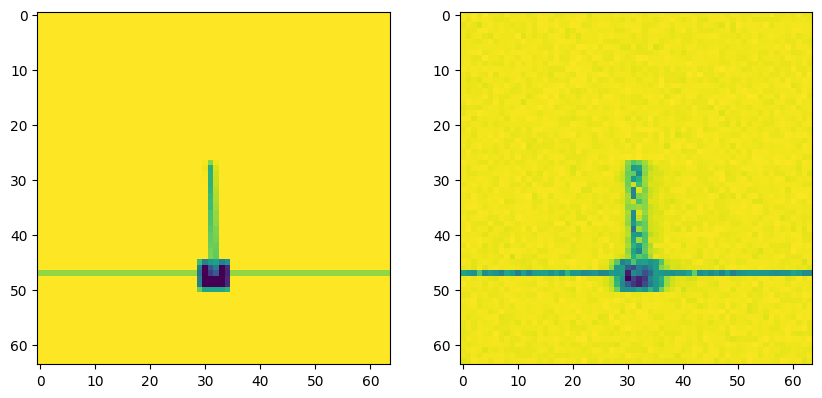

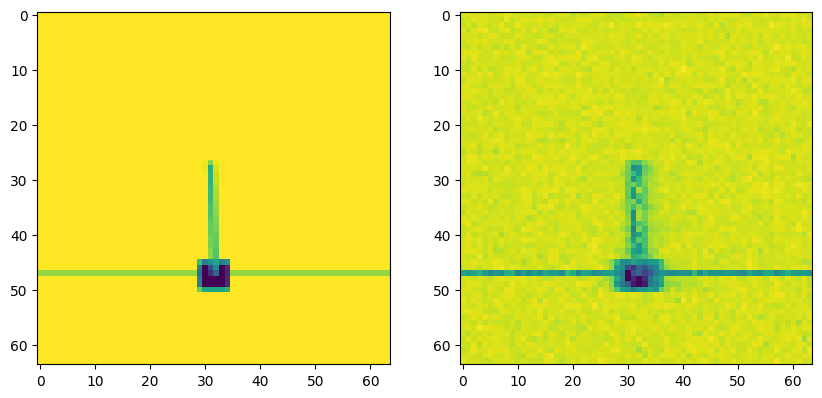

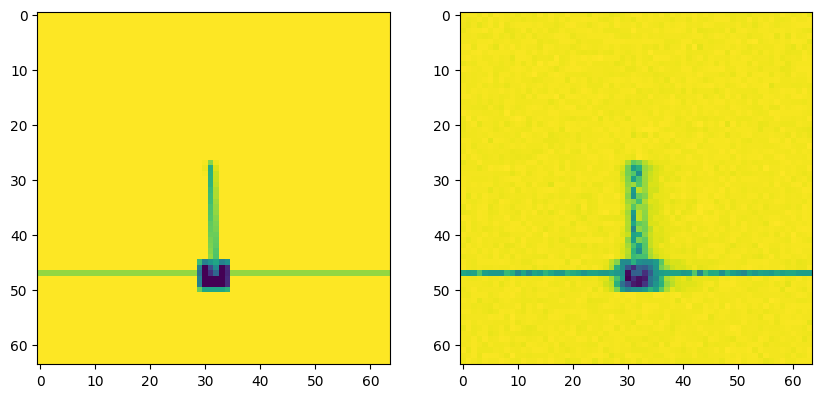

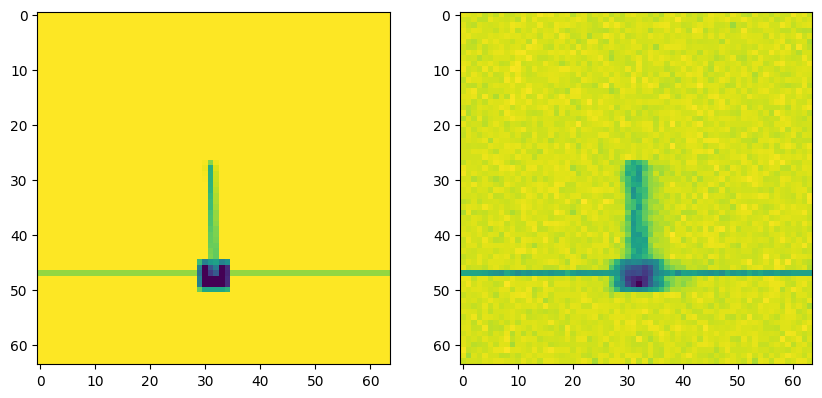

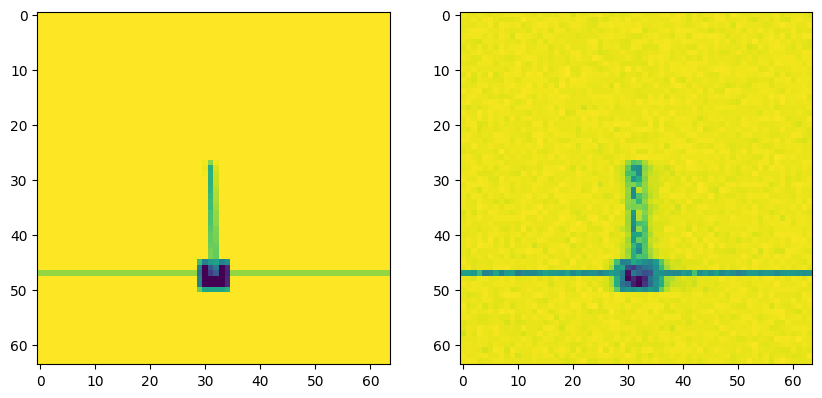

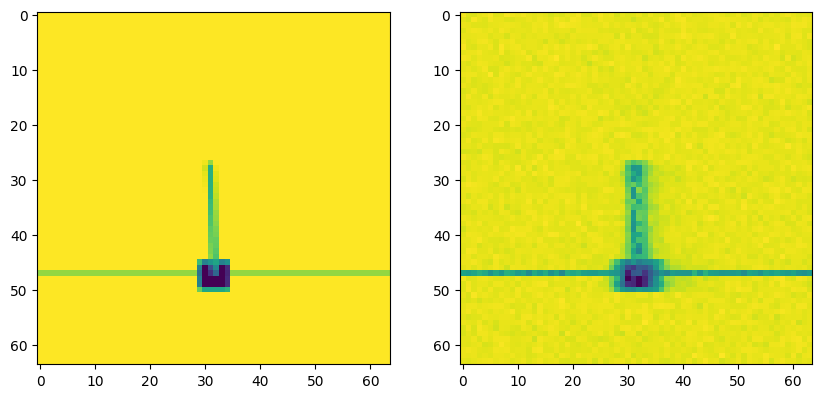

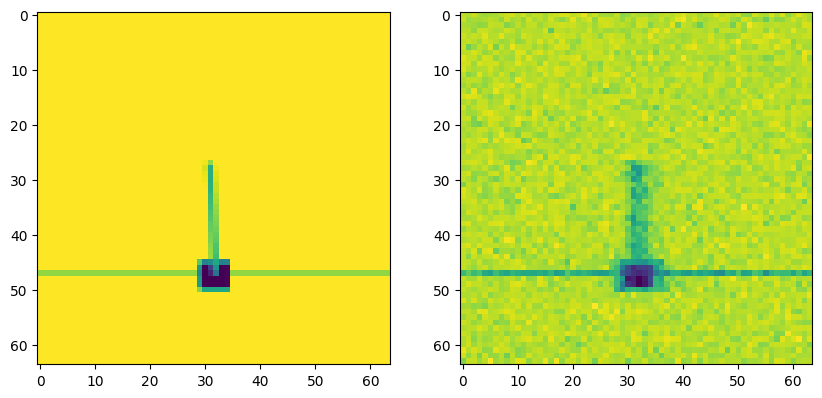

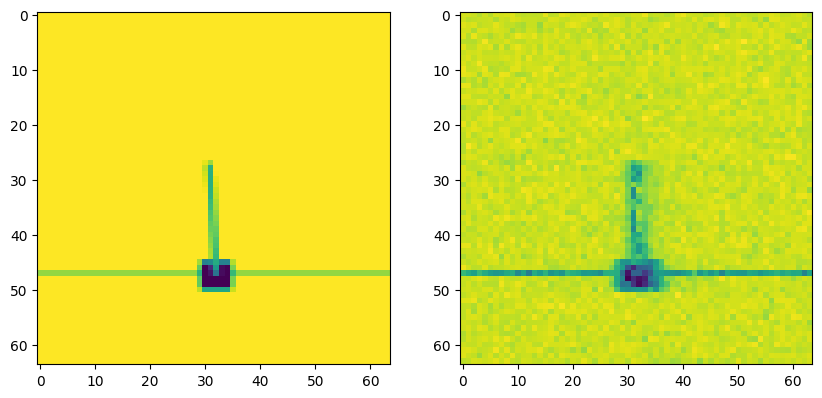

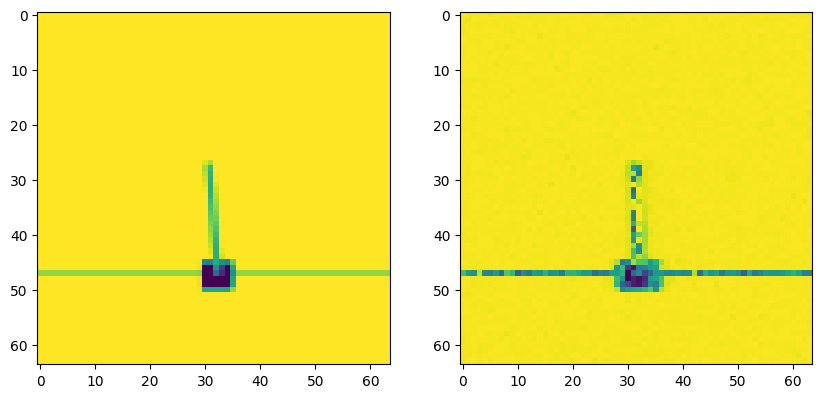

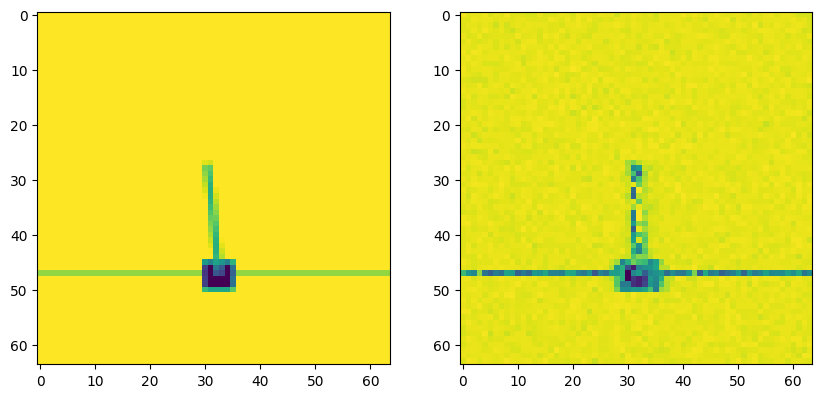

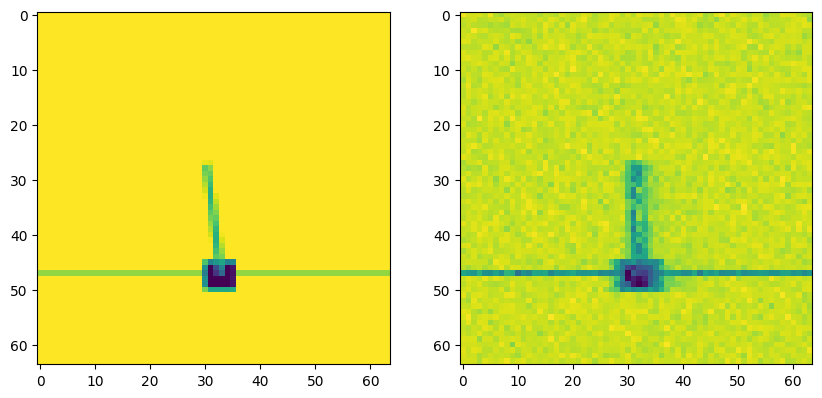

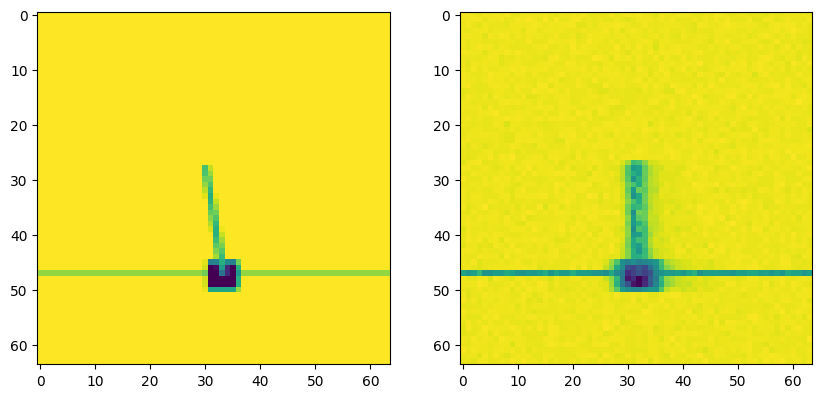

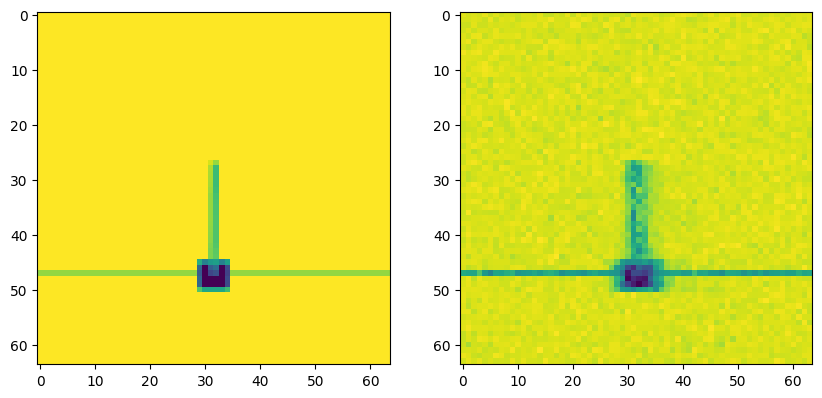

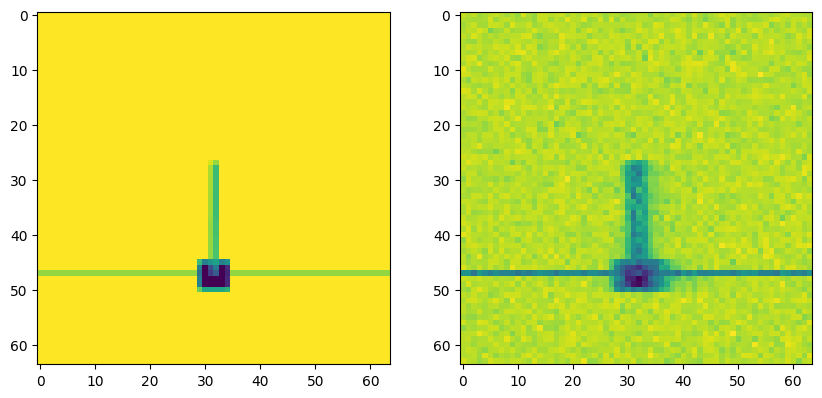

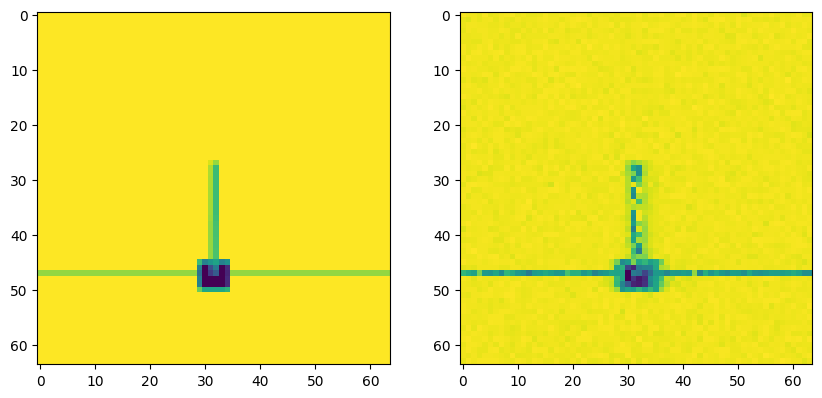

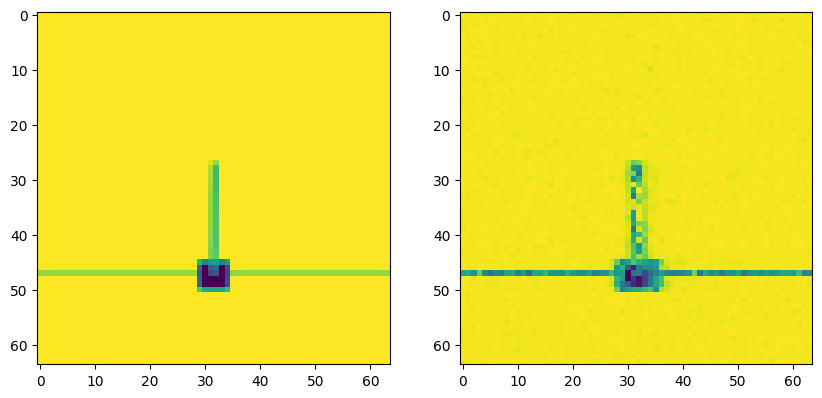

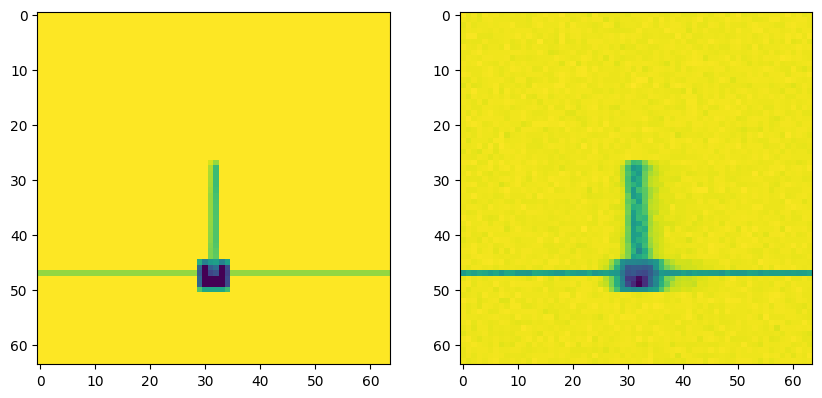

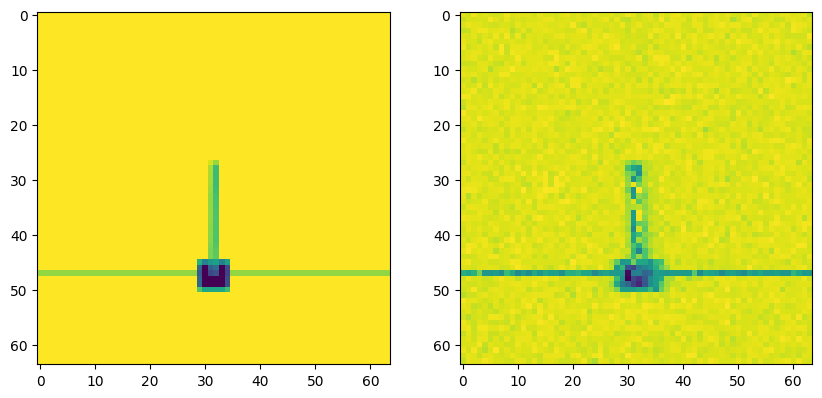

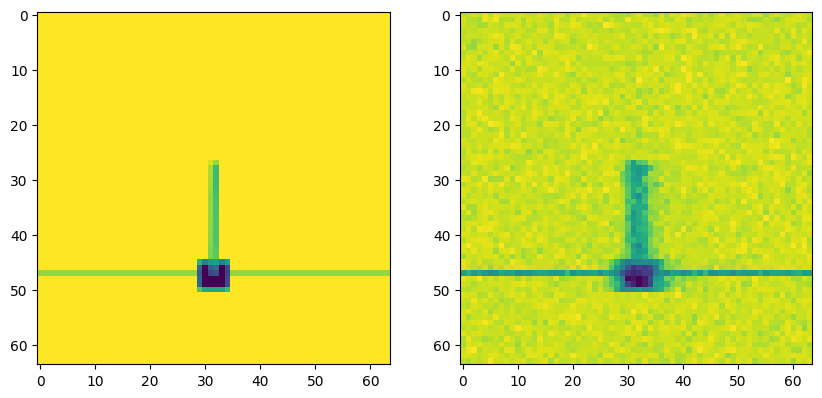

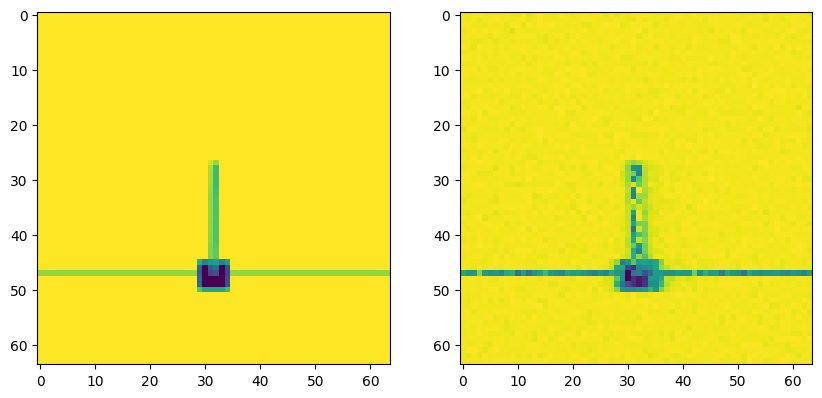

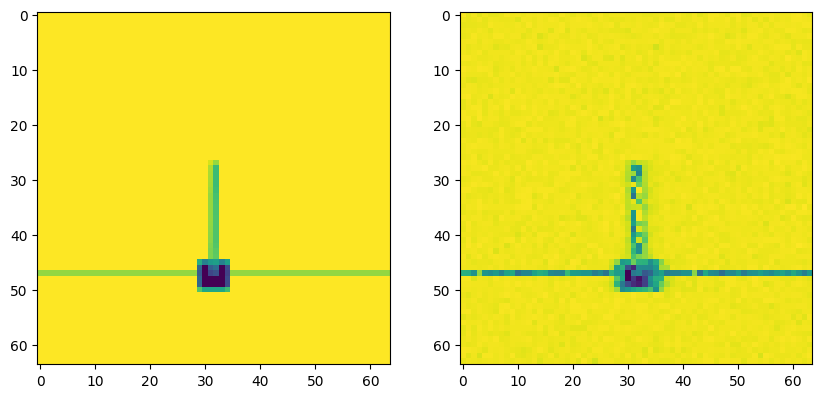

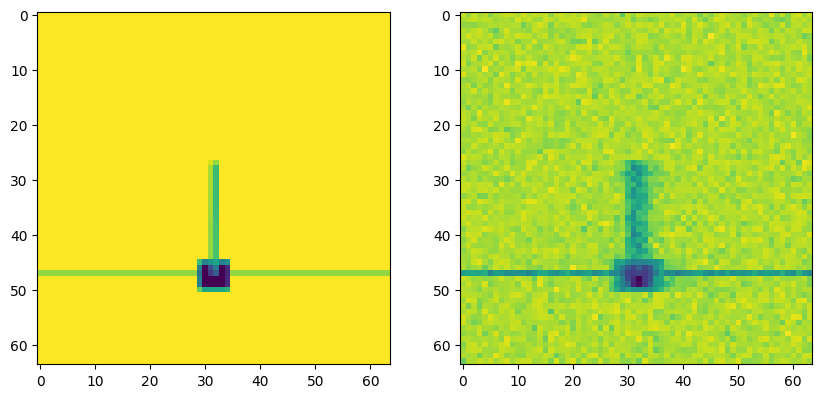

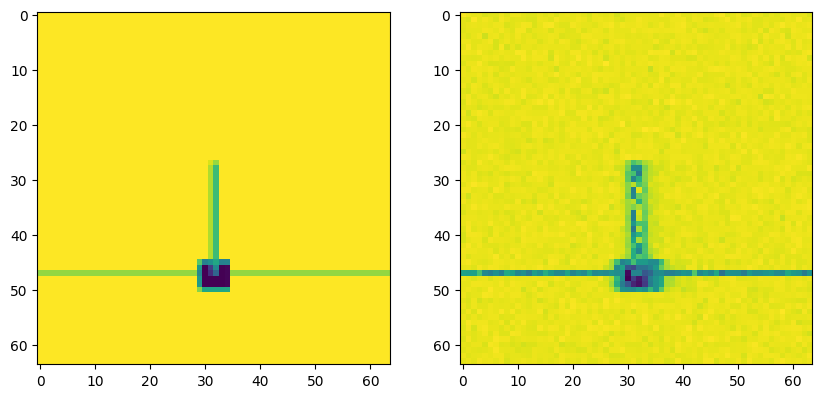

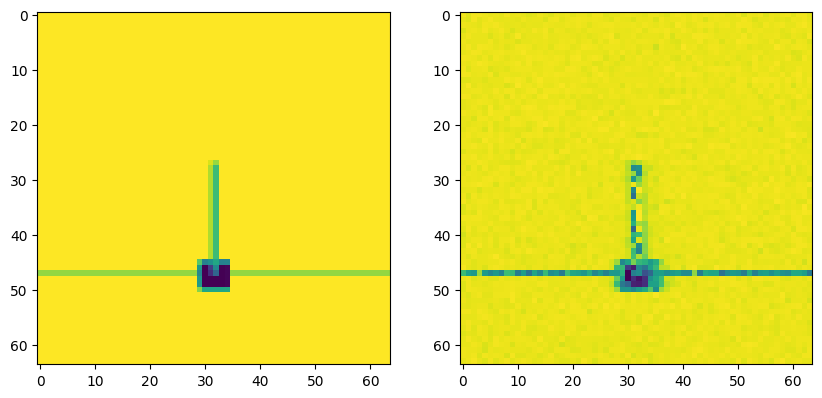

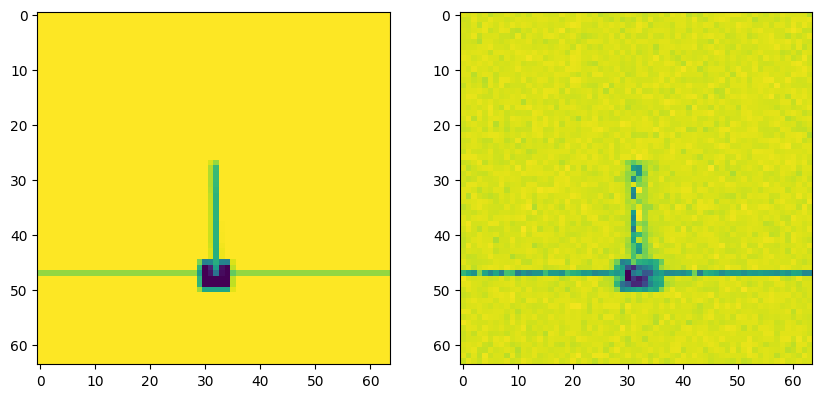

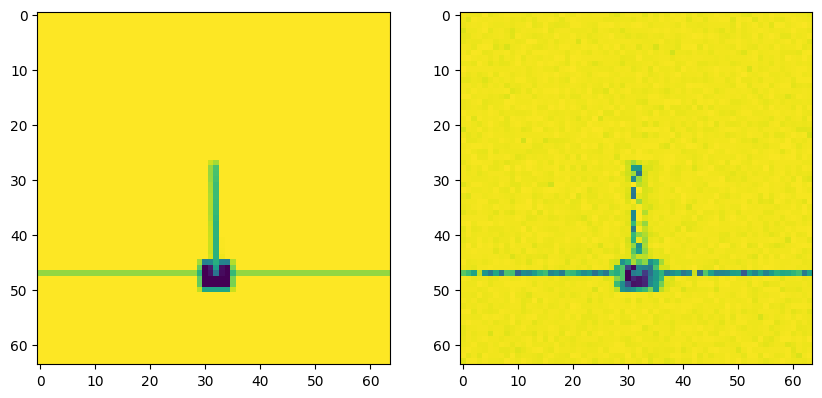

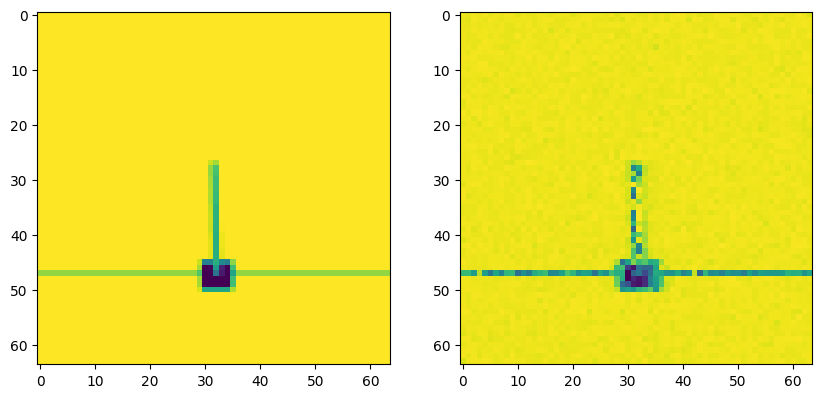

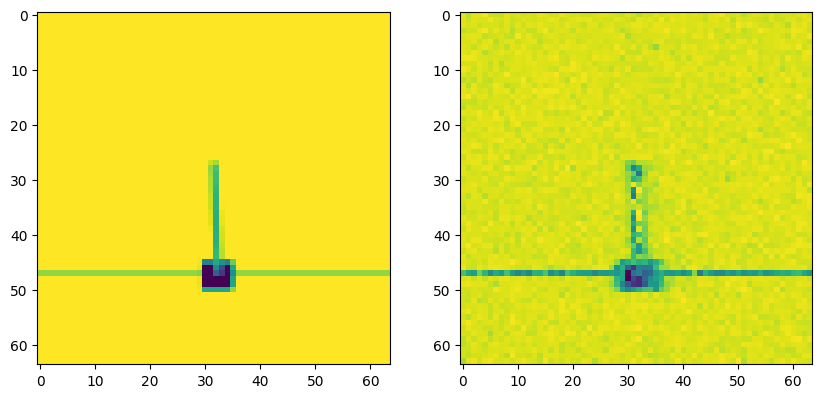

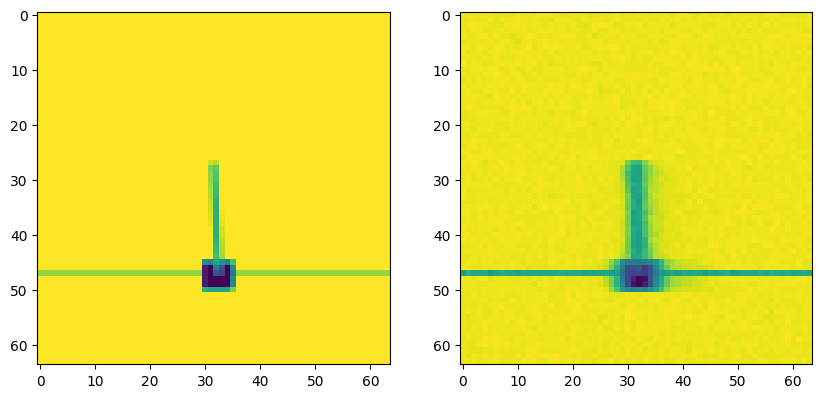

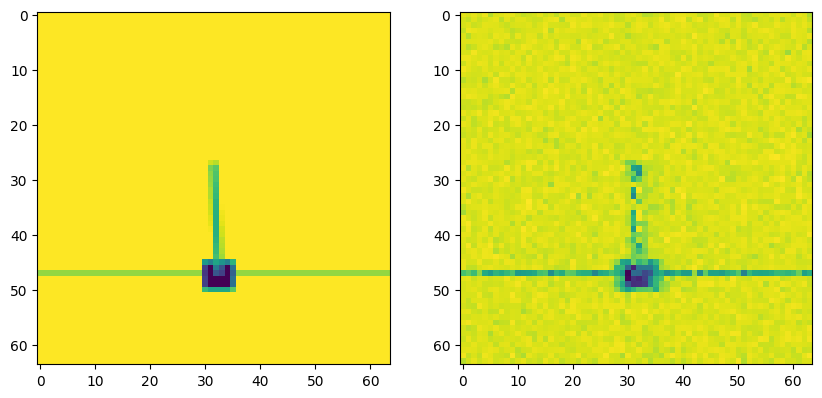

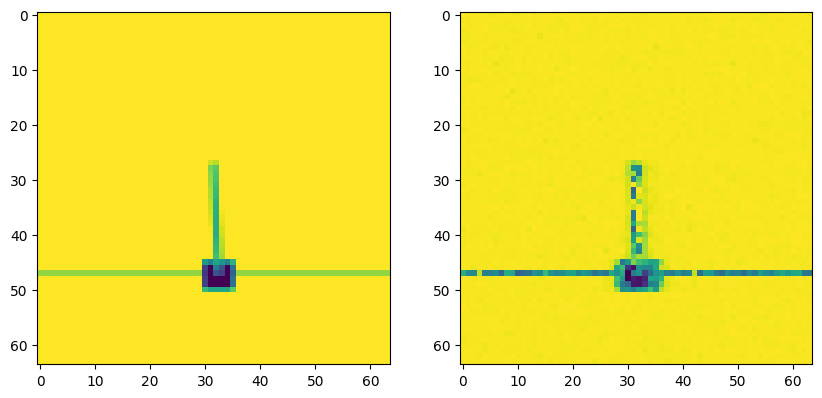

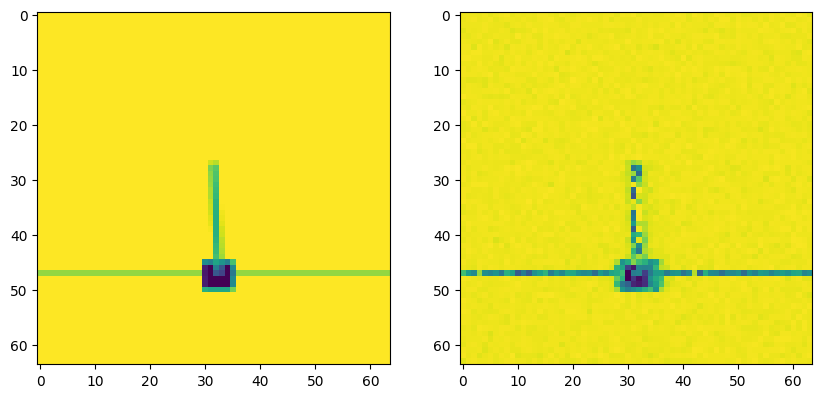

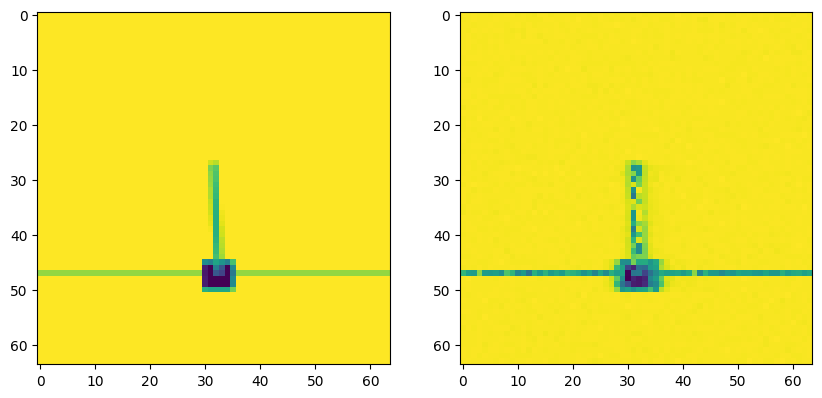

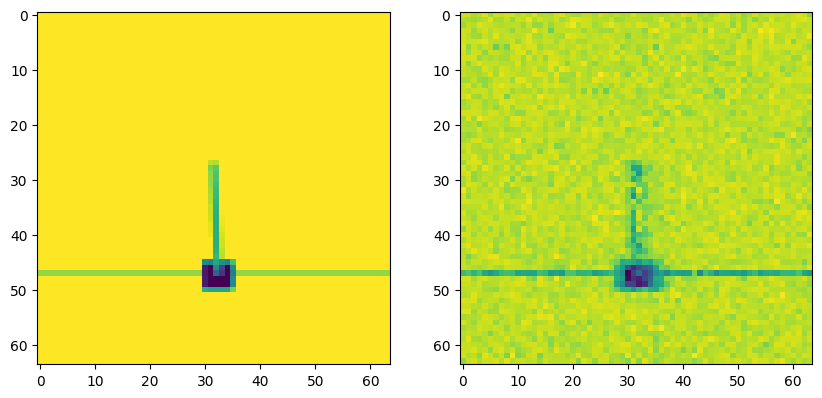

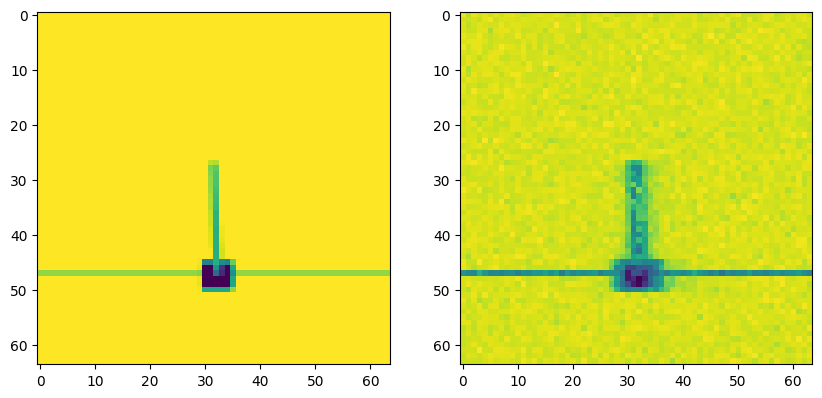

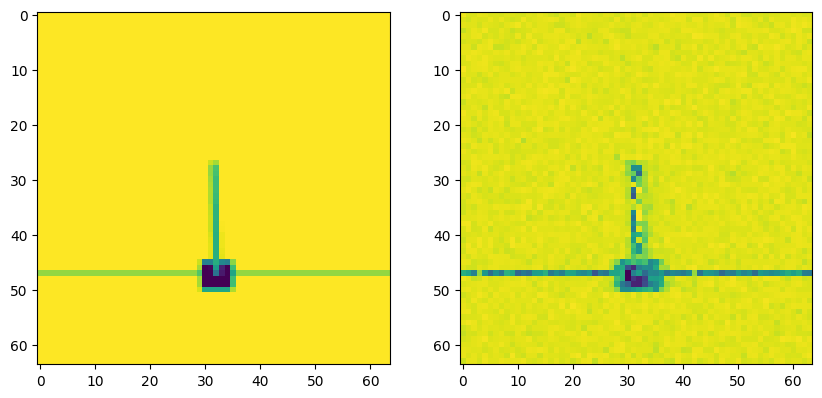

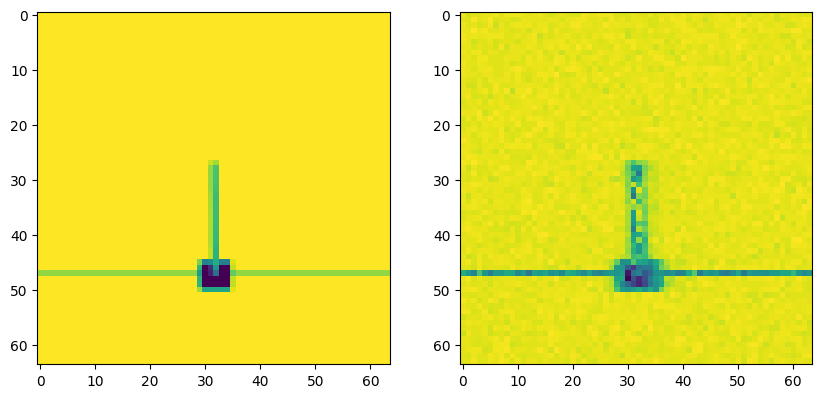

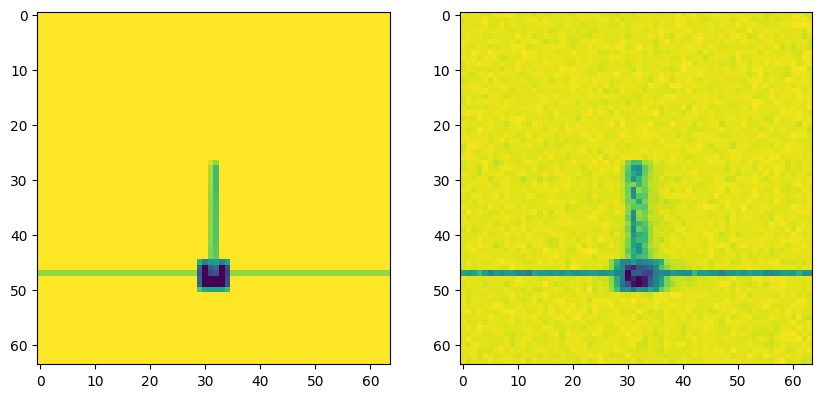

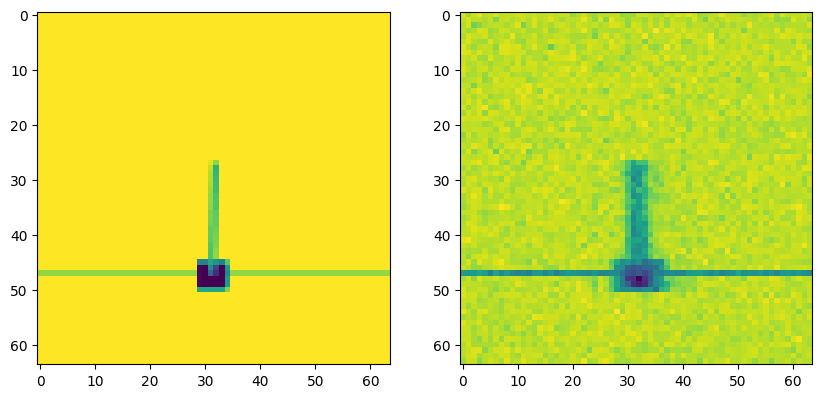

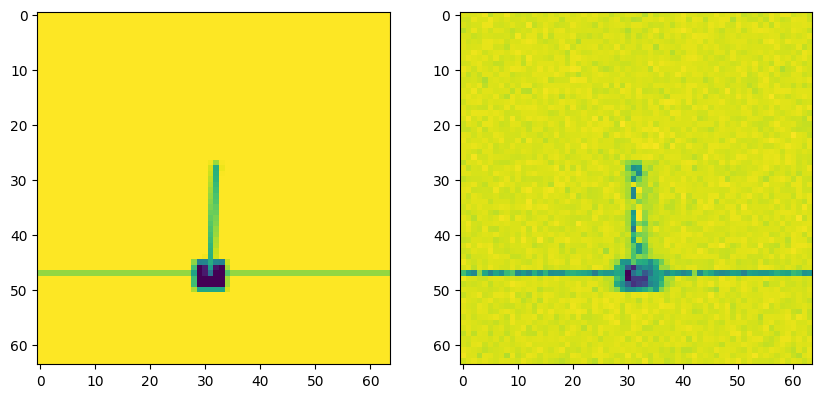

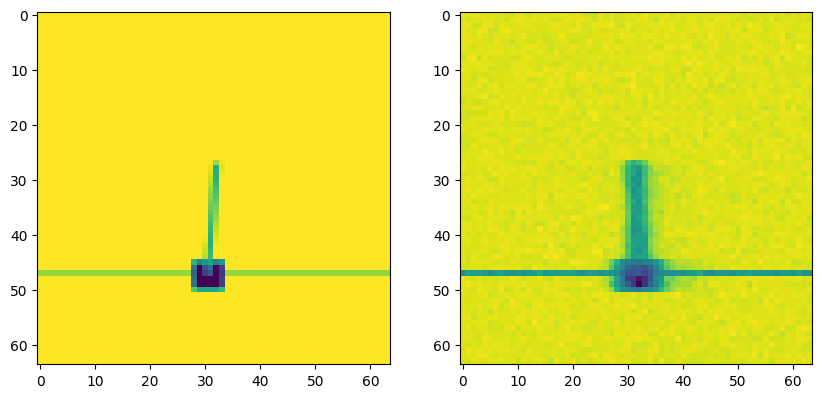

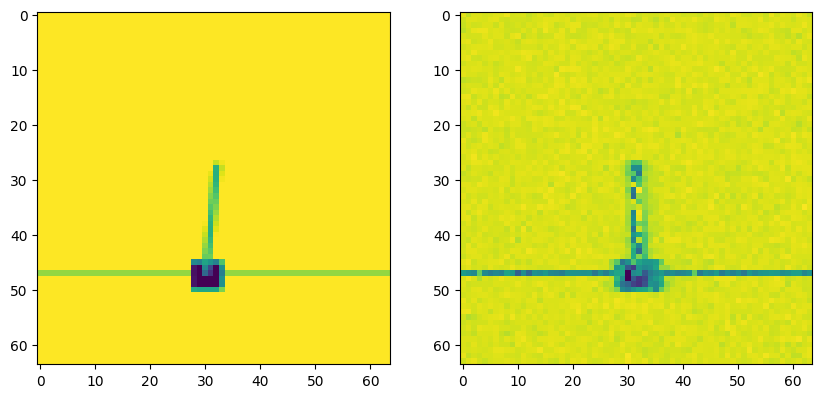

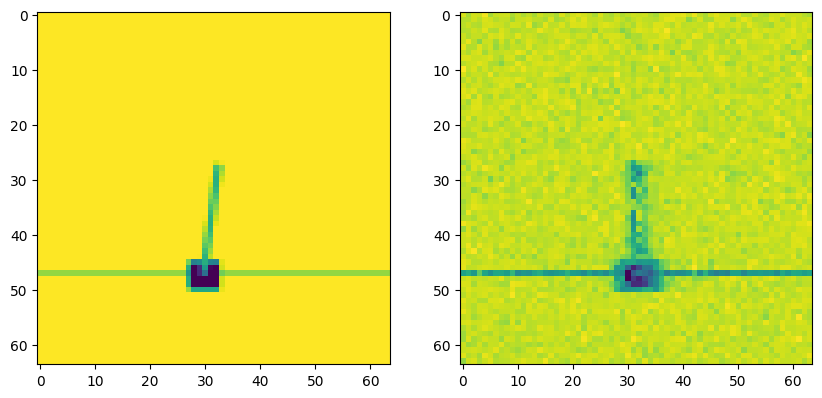

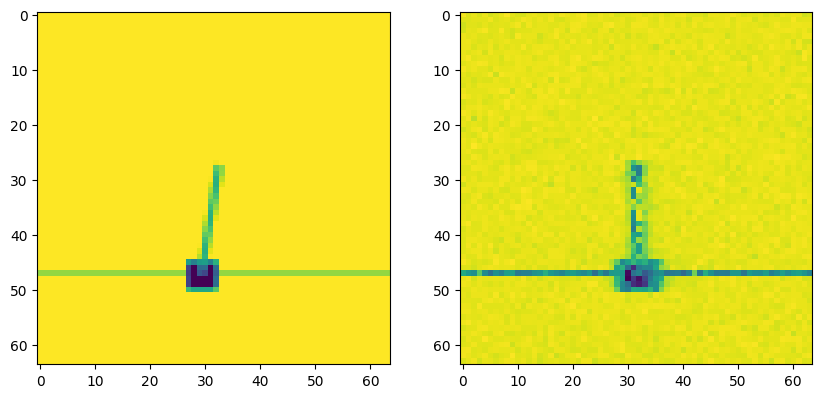

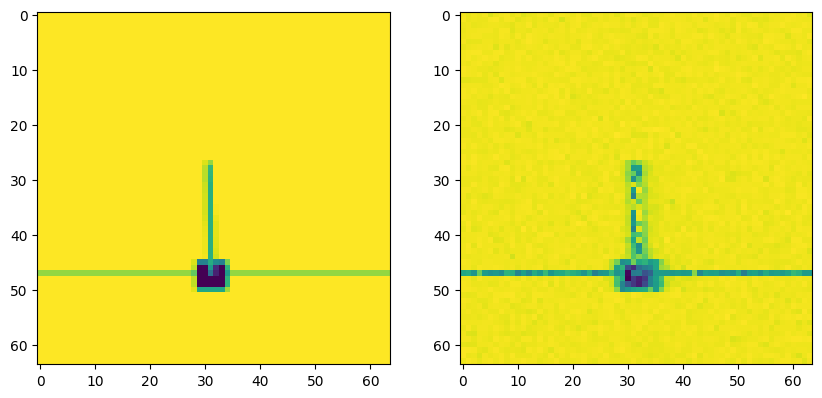

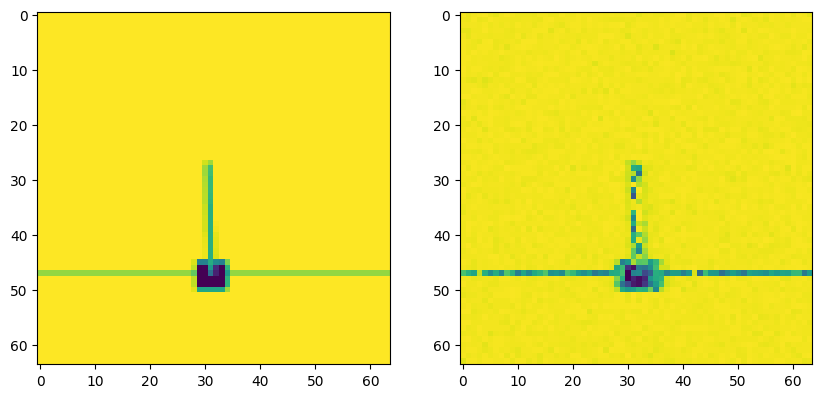

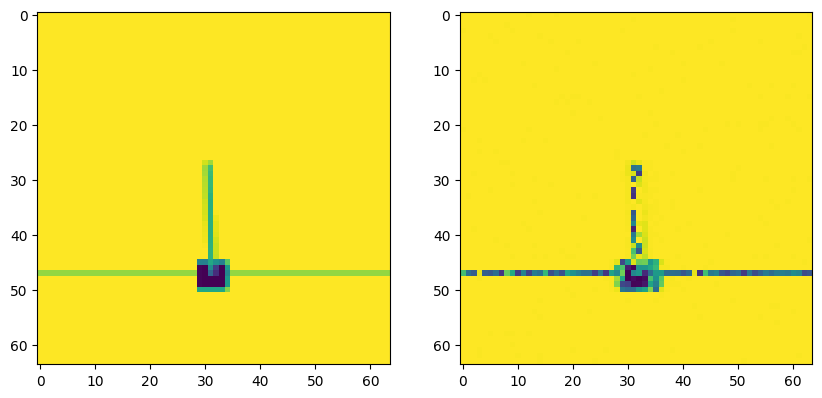

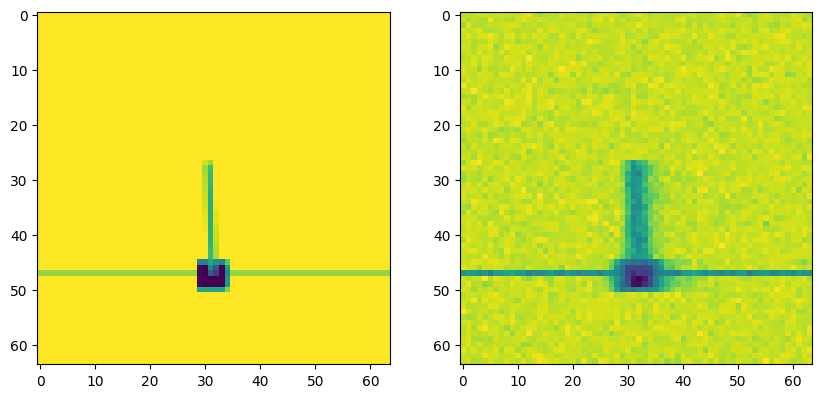

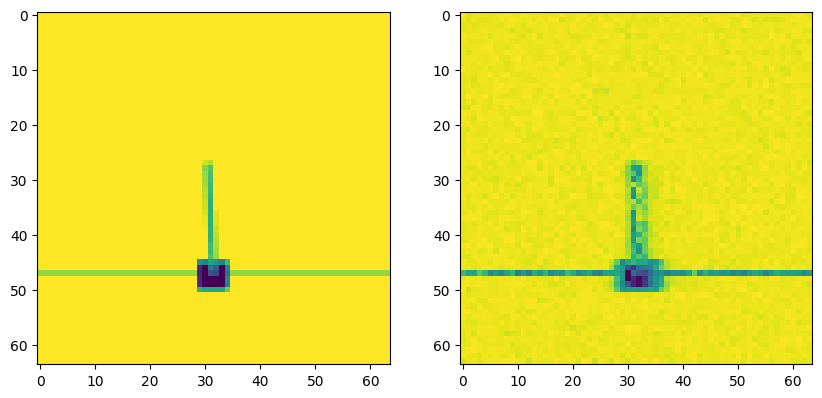

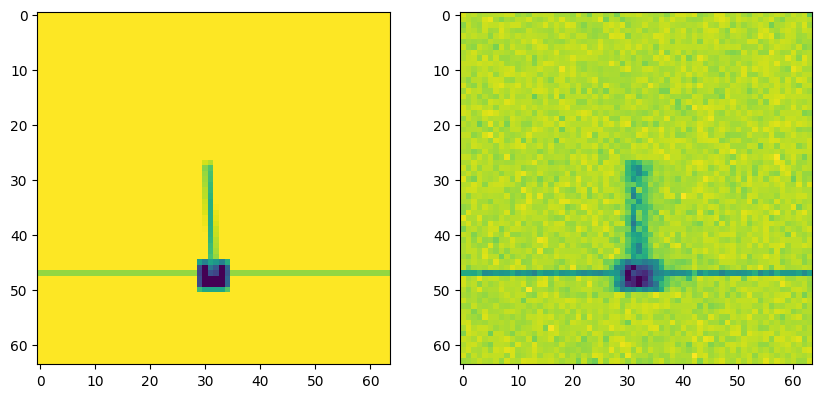

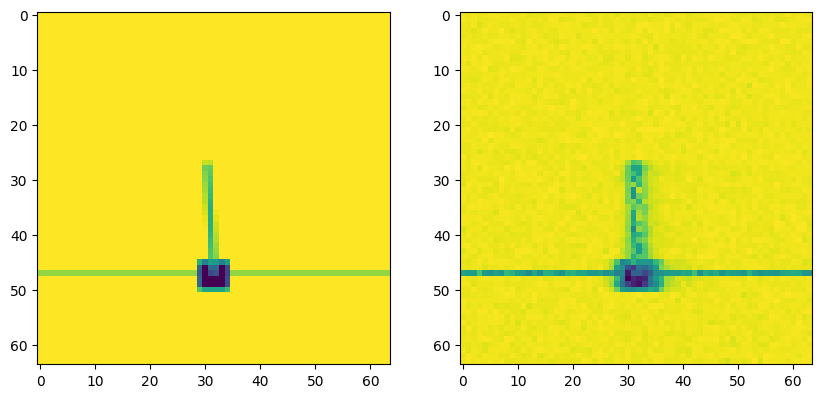

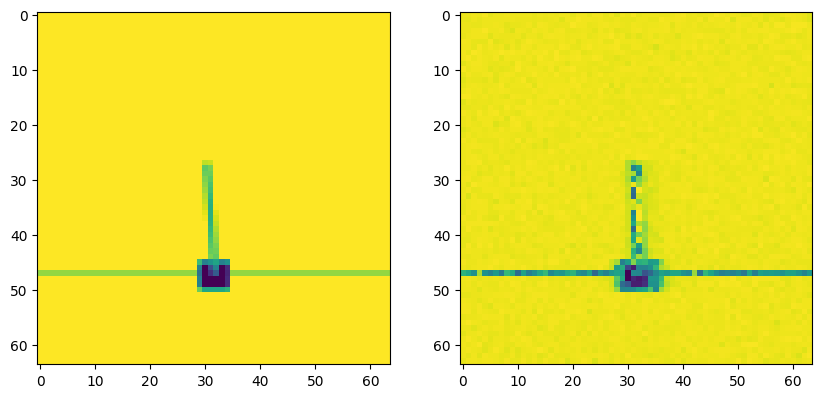

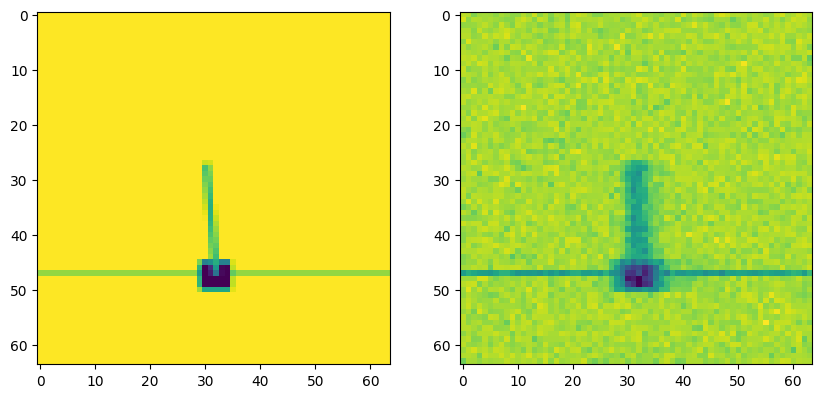

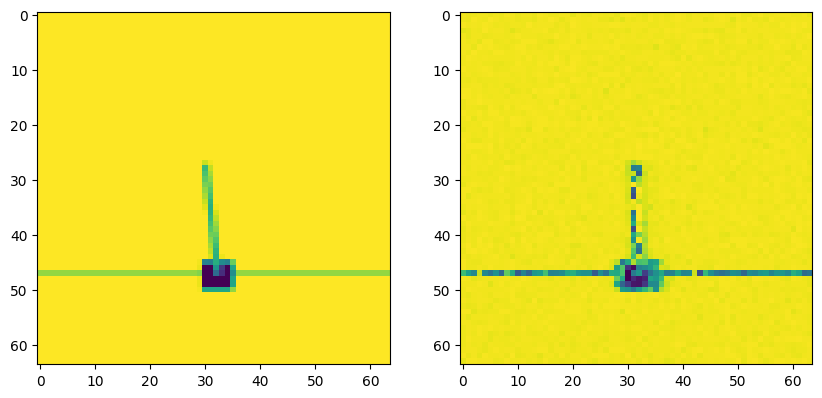

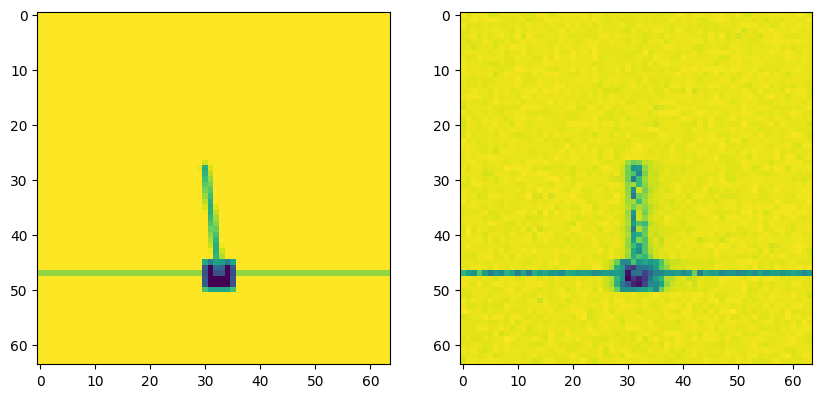

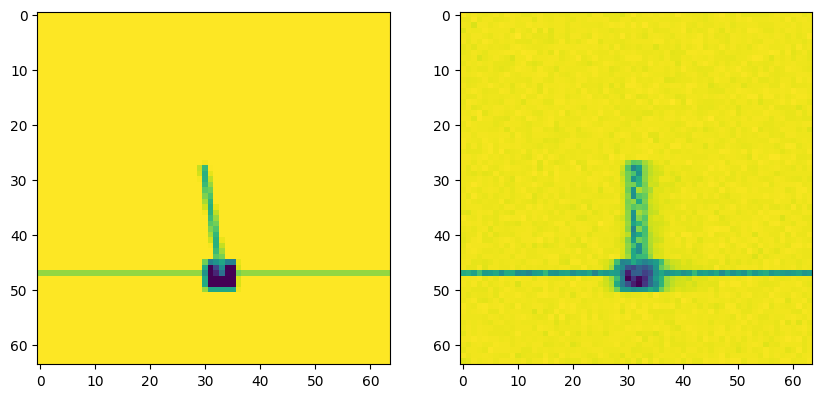

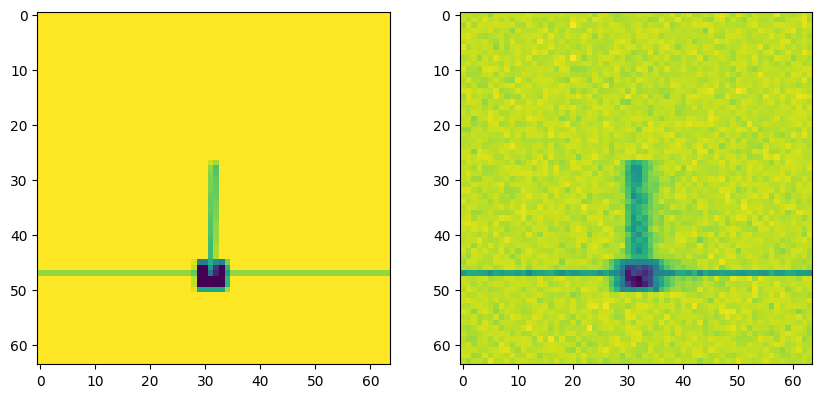

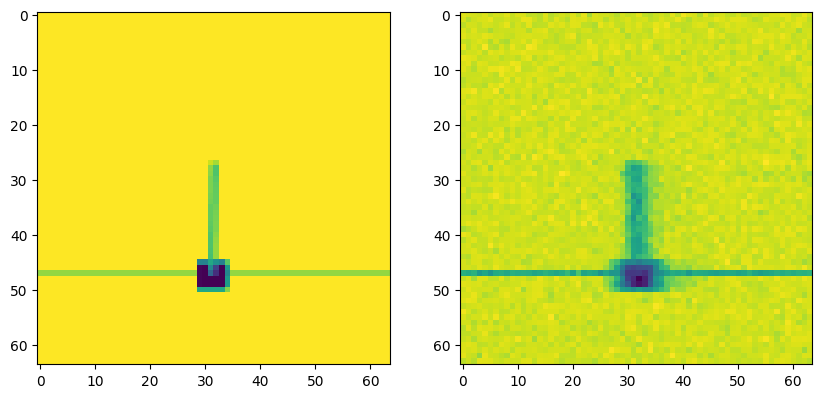

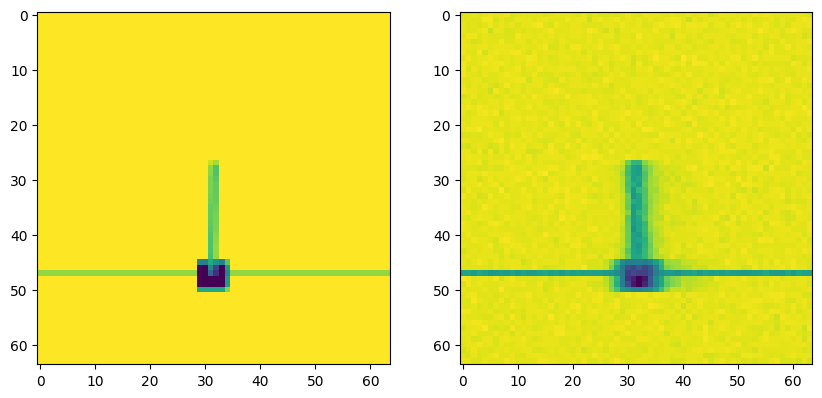

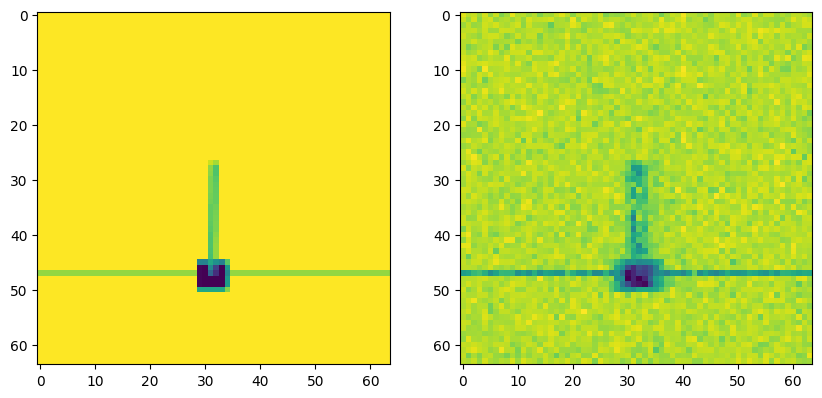

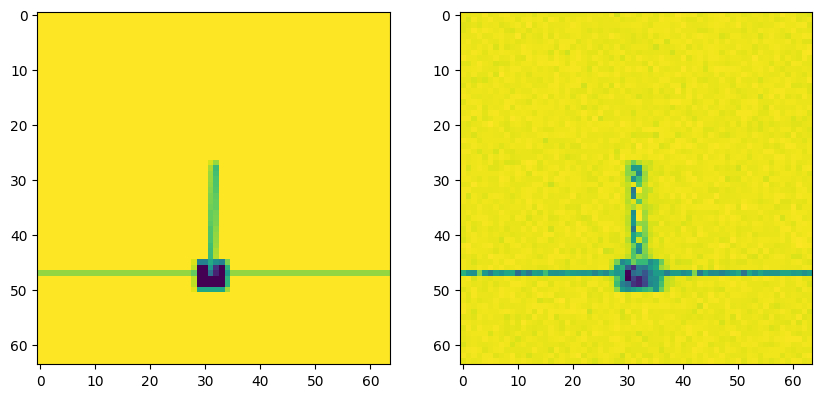

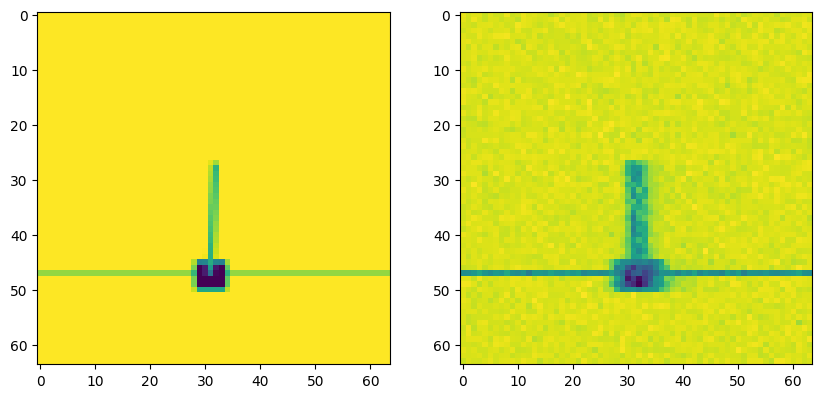

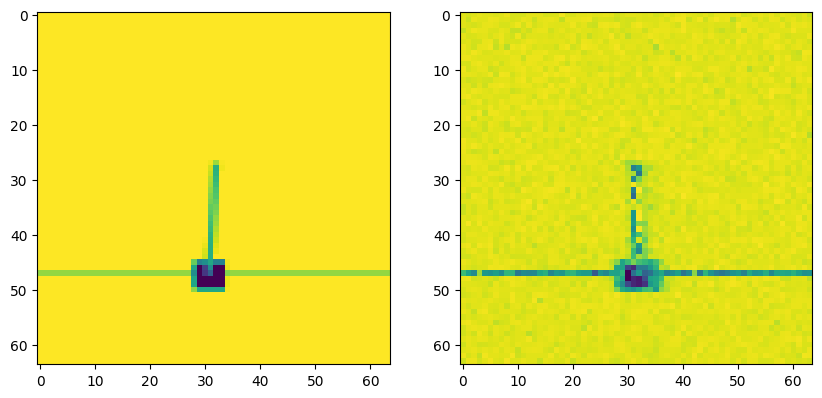

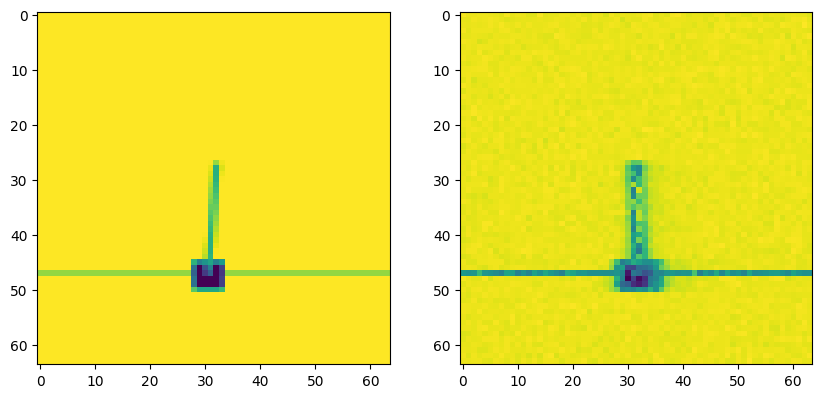

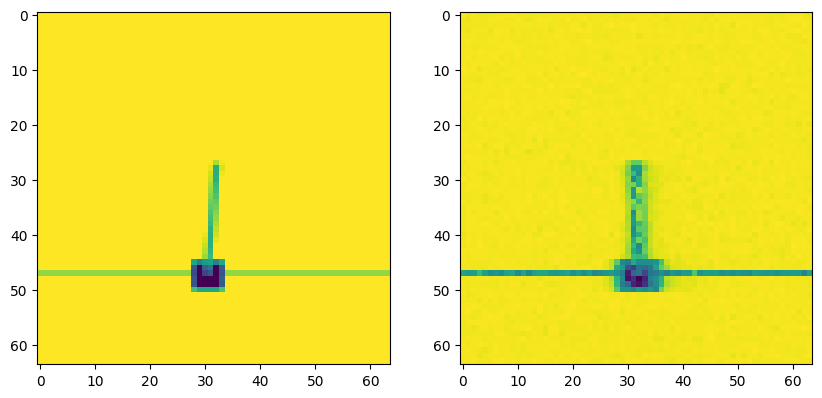

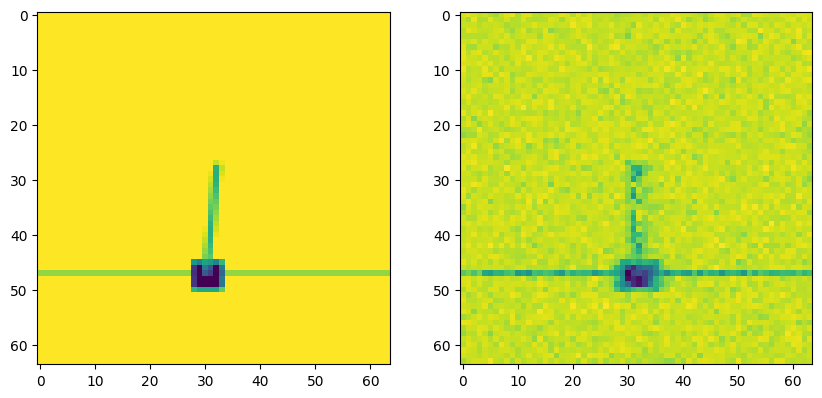

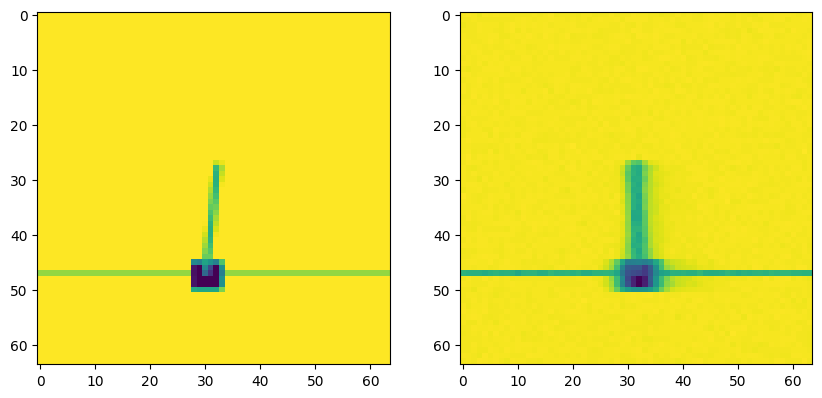

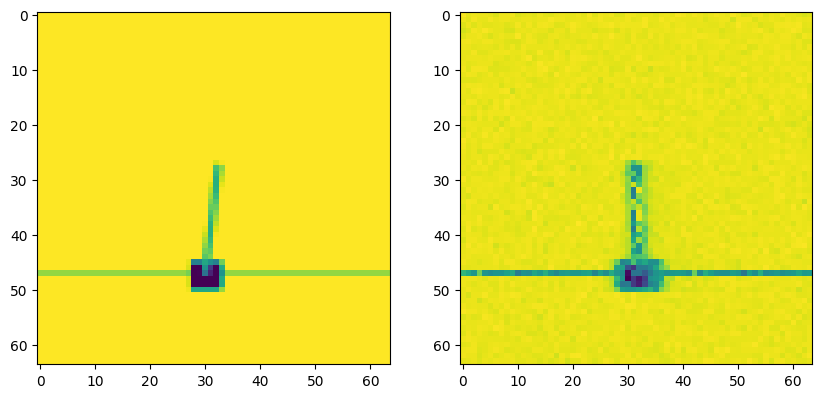

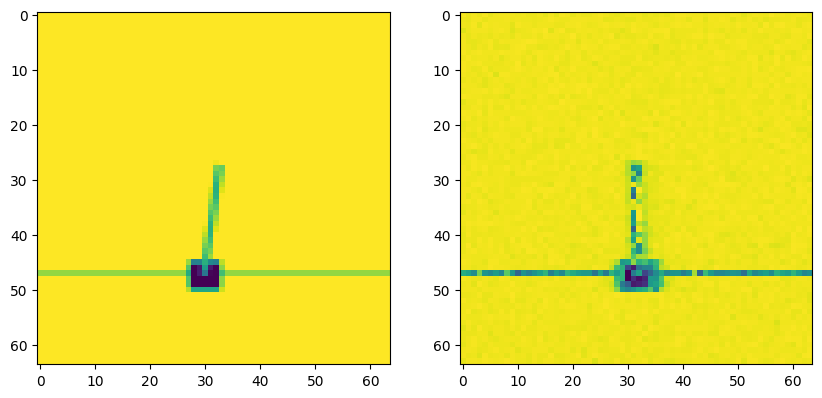

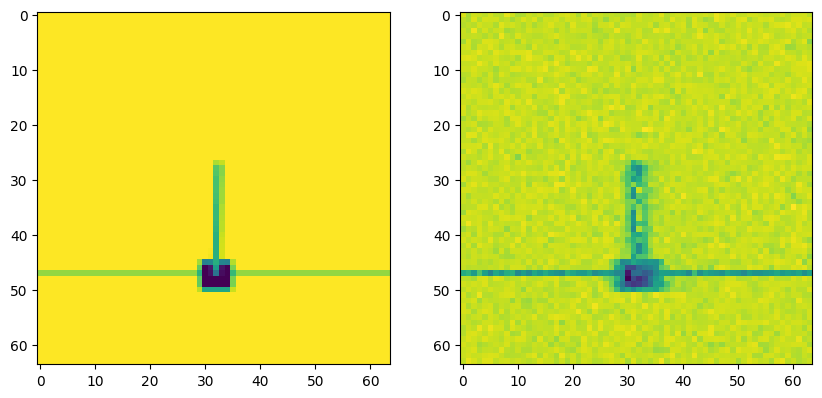

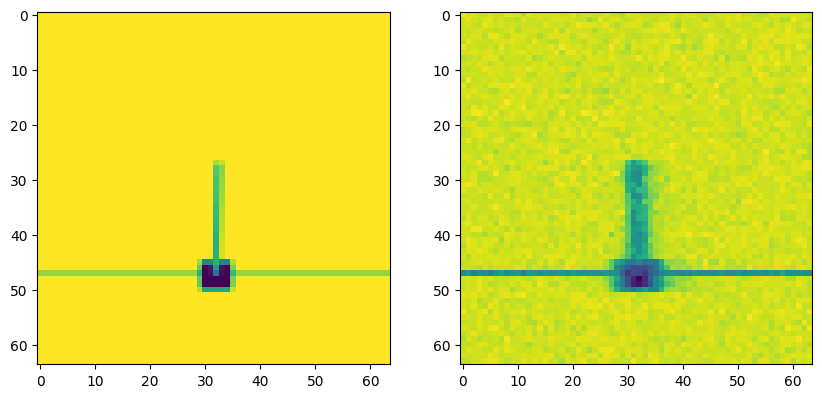

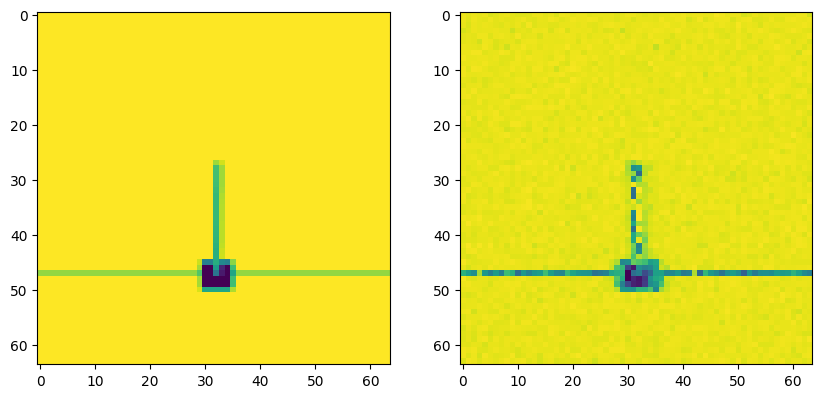

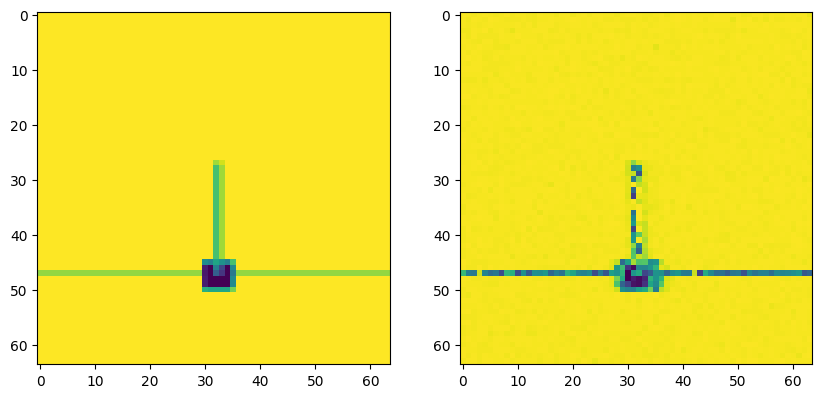

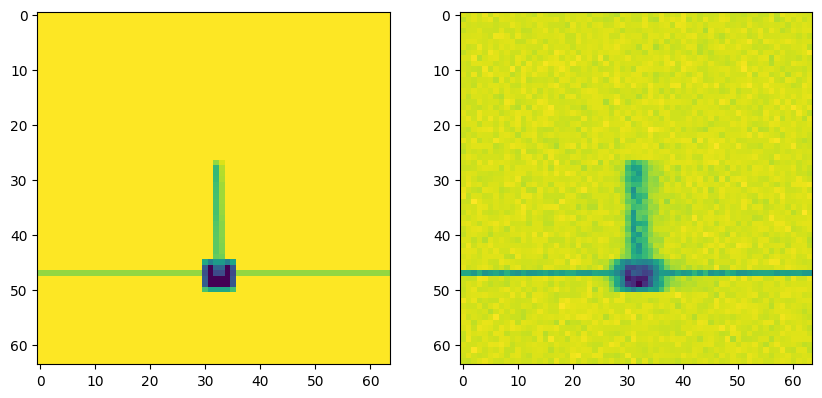

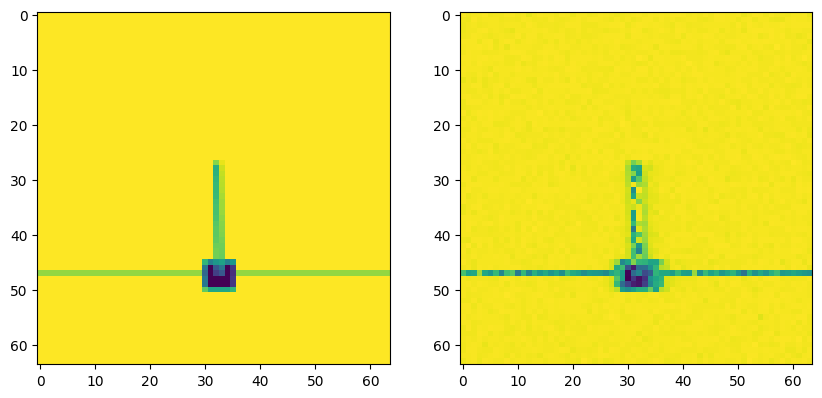

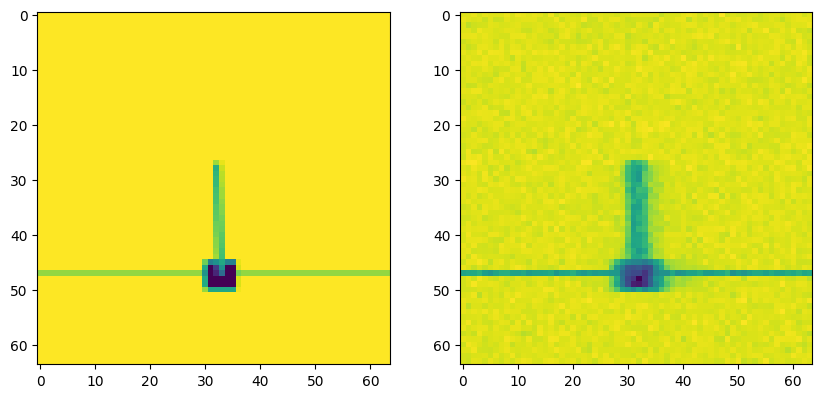

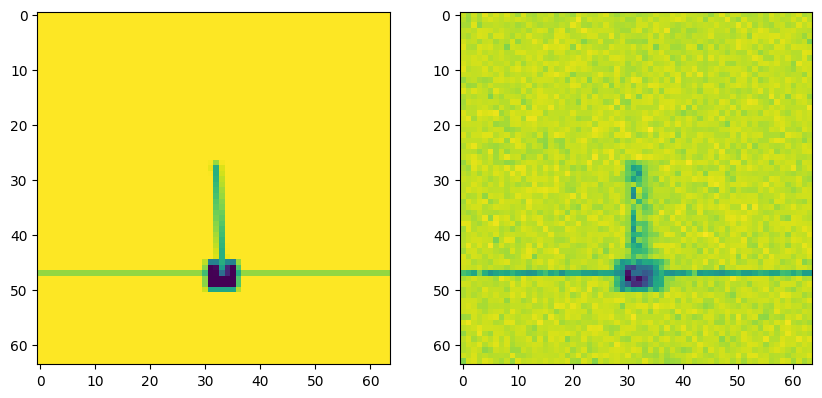

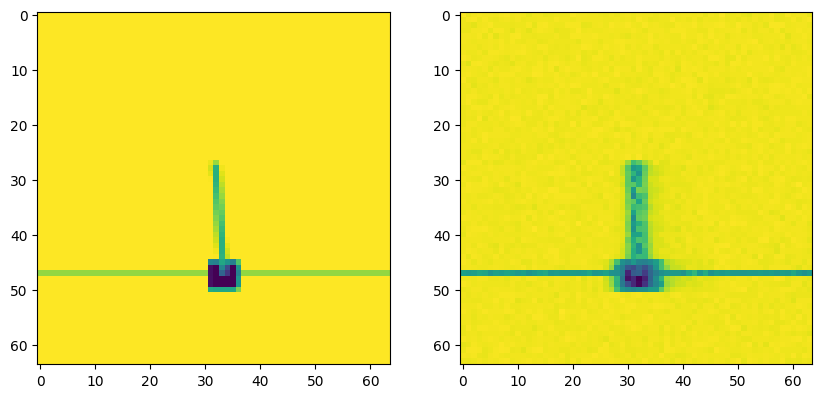

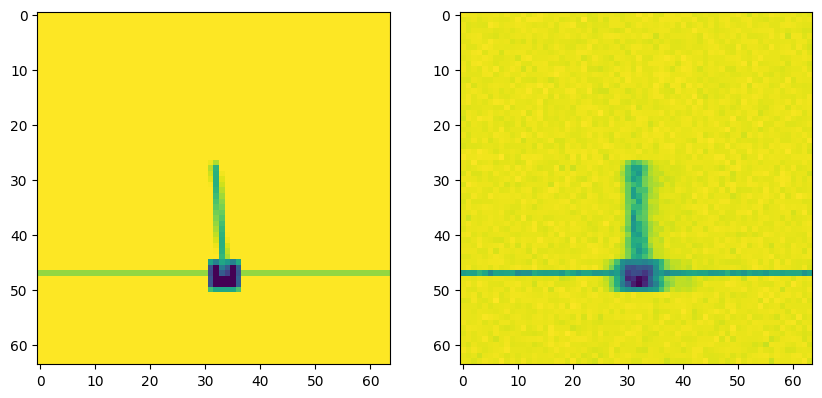

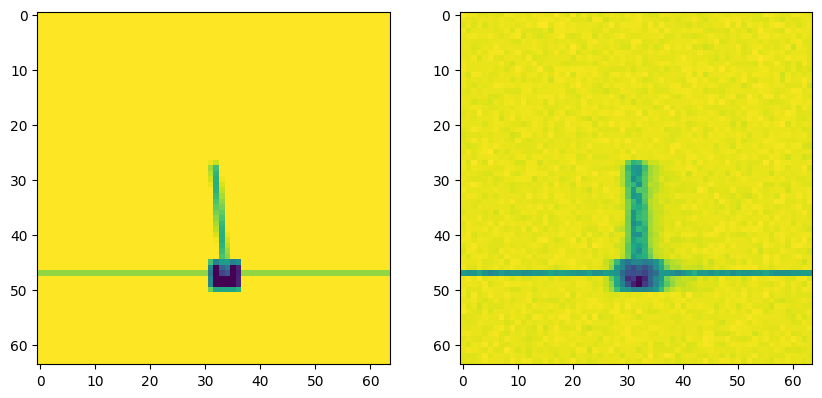

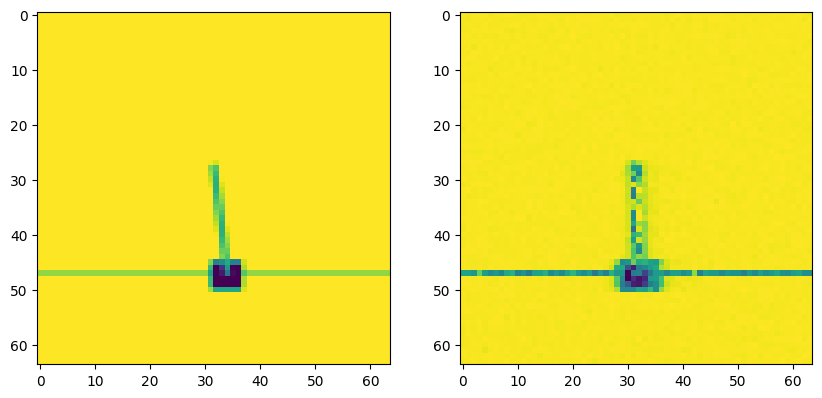

In [ ]:
import gym
import numpy as np
from gym.envs.classic_control import PendulumEnv
import torch as th
from stable_baselines3.sac.policies import CnnPolicy
from stable_baselines3 import SAC
from gym import Wrapper, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import collections
from PIL import Image
import cv2
import time as time
# from skimage.transform import rescale, resize, downscale_local_mean
def resize(frame , width, height):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
    return frame[:, :, ]

i = 0
def plot_encoded_decoded(img1 , img2):
  global i

  fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

  # Plot the first image on the left subplot
  axs[0, 0].imshow(img1)

  # Plot the second image on the right subplot
  axs[0, 1].imshow(img2)
  # Save the figure as a single image
  plt.savefig(f'recon/0000_{i}.png', dpi=300)
  i += 1

## image saving  compression image
class RGBArrayAsObservationWrapper(Wrapper):
    def __init__(self, env):
        super(RGBArrayAsObservationWrapper, self).__init__(env)

        env.reset() ## initialize the environment! for

        # dummy_obs = self.reset()## before PPO, we estimate the size image.
        self.num_repeats = 5 ## repeathing images to check the direction of the cartpole
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.num_repeats, 1 , 500), dtype=np.float32)
        self.dq = collections.deque(maxlen=self.num_repeats)
    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        obs = self.env.render("rgb_array")
        obs = resize(obs ,64 , 64)
        img = T.from_numpy(obs.reshape(1, -1)).float().to(device)
        obs , _ = encoder.encode(img)
        for _ in range(5): ## stacking the observation on the dq
            self.dq.append(obs.detach())
        obs_stacked = T.stack(tuple(self.dq))

        return obs_stacked.numpy()
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = self.env.render("rgb_array")
        img = resize(obs , 64, 64)

        t_img = T.from_numpy(img.reshape(1, -1)).float().to(device)
        mean , var = encoder.encode(t_img)


        std = T.exp(0.5 * var)

        obs = T.distributions.Normal(loc=mean, scale=std).sample()


        decoded_img = encoder.decode(obs).detach().numpy()
        decoded_img = decoded_img.reshape(64, 64)

        plot_encoded_decoded(img , decoded_img)


        # Save the image
        self.dq.append(obs.detach())
        obs_stacked = T.stack(tuple(self.dq))
        # print(obs_stacked)
        return obs_stacked, reward, done, info


start = time.time()
TEST_COUNT = 100
pendulum_env = gym.make("CartPole-v1")
pendulum_env = RGBArrayAsObservationWrapper(pendulum_env)
pendulum_env.reset()
log_dir = "logs/"

os.makedirs(log_dir, exist_ok=True)## make directory

# env.env.ale.saveScreenPNG('test_image2.png')
env = Monitor(pendulum_env, log_dir) ##monitor wrapper for Gym environments, it is used to know the episode reward, length, time and other data.
model = PPO("MlpPolicy", env, verbose=1) ## use the PPO model and verbose = 0 with the cnnpolicy
## line 44-45 through this policy and with PPO model and enviroment and doing the CNN policy.
model.learn(100000) ## running times of stpes
end = time.time()
timecost = end - start
print(timecost)
